In [1]:
#!/usr/bin/env python

# UV10_station_analysis.ipynb

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import netCDF4
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
rgsLableABC=list(string.ascii_lowercase)

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km


In [3]:
### kinetic energy spectra programs from Julia
def get_ke(u_wind, v_wind):
    """
    Function to compute kinetic energy from horizontal wind. 
    
    Args: 
        uwind(xarray.DataArray): 2D or 3D (when time dimension is included) field with u-component of wind
        vwind(xarray.DataArray): 2D or 3D (when time dimension is included) field with v-component of wind
     
    
    """
    kinetic_energy = 0.5 * (u_wind**2 + v_wind**2)
    
    return kinetic_energy


def get_variances(spectral):
    """
    This function computes sigma squared
    (variances of the spectral coefficients).

    Args:
        spectral(np.array): 2D array with spectral coefficients
    Returns:
        variance(np.array): 2D array with variances

    """
    Ni = spectral.shape[0]
    Nj = spectral.shape[1]
    return (spectral ** 2) / (Ni * Nj)

def get_power_spectrum(variance, dx):
    """
    This function creates a power spectrum for a given field
    of spectral variances.

    Args:
        variance(np.array): 2D field of sigma squared (variances of spectral coefficients)
        dx(float): grid spacing in m or km
    Returns:
        wavelengths(np.array): 1D array with wavelengths (same unit as dx)
        histogram(np.array): binned variances corresponding to wavelengths

    """
    Ni = variance.shape[0]
    Nj = variance.shape[1]
    m, n = np.meshgrid(np.arange(Ni), np.arange(Nj), indexing = 'ij')

    # to ensure that the number of wavenumber bands is not larger than any axis of the domain
    mindim = min(Ni, Nj)
    # array with wavenumber bands
    k = np.arange(1, mindim)
    # normalized k for each element in k space, alpha max should be square root of 2! 
    alpha = np.sqrt(m ** 2 / Ni ** 2 + n ** 2 / Nj ** 2)
    # limits of contributing bands
    lowerbound = k / mindim
    upperbound = (k+1)/ mindim
    
    # binning 
    histogram, bins = np.histogram(alpha.flatten(), bins=upperbound, weights=variance.flatten())
    alpha_mean = np.nanmean([lowerbound, upperbound], axis = 0 )
    wavelengths = 2 * dx / alpha_mean

    return wavelengths, histogram

#### functions to convert between non-dimensional/dimensional wavenumbers and wavelength 

def lambda_to_k(wavelengths):
    """
    This function convert wavelengths lambda in km to wavenumbers k 
    in rad/m. 
    """
    return 2* np.pi/ (wavelengths * 1000)


def k_to_lambda(Ni, Nj, dx):
    """
    This function converts the non-dimensional wavenumbers
    of a 2D k-space to wavelengths that represent the real spatial scale.

    Args:
        Ni(int): number of grid cells in y-direction
        Nj(int): number of grid cells in x-direction
        dx(float): grid spacing in m or km

    Returns:
        lambda_mn(np.array): 2D array with wavelengths for
                            each m,n -pair. The output unit is
                            same unit given for dx.
    """
    m, n = np.meshgrid(np.arange(Ni), np.arange(Nj), indexing = 'ij')
    k = np.sqrt(m ** 2 + n ** 2)

    ########   squared domain case   ##########
    if Ni == Nj:
        lambda_mn = (2 * Ni * (dx)) / k

    else:
        ######## rectangular domain case ##########

        ## normalization of k
        alpha = np.sqrt(m ** 2 / Ni ** 2 + n ** 2 / Nj ** 2)
        # compute wavelength
        lambda_mn = 2 * dx / alpha

    return lambda_mn

In [4]:
def ReadERA5(TIME,      # Time period to read (this program will read hourly data)
            var,        # Variable name. See list below for defined variables
            PL,         # Pressure level of variable
            REGION):    # Region to read. Format must be <[N,E,S,W]> in degrees from -180 to +180 longitude
           
    # ----------
    # This function reads hourly ERA5 data for one variable from NCAR's RDA archive in a region of interest.
    # ----------

    DayStart = datetime.datetime(TIME[0].year, TIME[0].month, TIME[0].day,TIME[0].hour)
    DayStop = datetime.datetime(TIME[-1].year, TIME[-1].month, TIME[-1].day,TIME[-1].hour)
    TimeDD=pd.date_range(DayStart, end=DayStop, freq='d')
    Plevels = np.array([1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000])

    dT = int(divmod((TimeDD[1] - TimeDD[0]).total_seconds(), 60)[0]/60)
    
    # check if variable is defined
    if var == 'V':
        ERAvarfile = 'v.ll025uv'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'
        NCvarname = 'V'
        PL = np.argmin(np.abs(Plevels - PL))
    if var == 'U':
        ERAvarfile = 'u.ll025uv'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'
        NCvarname = 'U'
        PL = np.argmin(np.abs(Plevels - PL))
    if var == 'T':
        ERAvarfile = 't.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'
        NCvarname = 'T'
        PL = np.argmin(np.abs(Plevels - PL))
    if var == 'ZG':
        ERAvarfile = 'z.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'
        NCvarname = 'Z'
        PL = np.argmin(np.abs(Plevels - PL))
    if var == 'Q':
        ERAvarfile = 'q.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'
        NCvarname = 'Q'
        PL = np.argmin(np.abs(Plevels - PL))
    if var == 'SLP':
        ERAvarfile = 'msl.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/'
        NCvarname = 'MSL'
        PL = -1
    if var == 'IVTE':
        ERAvarfile = 'viwve.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/'
        NCvarname = 'VIWVE'
        PL = -1
    if var == 'IVTN':
        ERAvarfile = 'viwvn.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/'
        NCvarname = 'VIWVN'
        PL = -1
    if var == 'u10':
        ERAvarfile = '10u.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/'
        NCvarname = 'VAR_10U'
        PL = -1
    if var == 'v10':
        ERAvarfile = '10v.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/'
        NCvarname = 'VAR_10V'
        PL = -1

    print(ERAvarfile)
    # read in the coordinates
    ncid=Dataset("/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc", mode='r')
    Lat=np.squeeze(ncid.variables['latitude'][:])
    Lon=np.squeeze(ncid.variables['longitude'][:])
    # Zfull=np.squeeze(ncid.variables['Z'][:])
    ncid.close()
    if np.max(Lon) > 180:
        Lon[Lon >= 180] = Lon[Lon >= 180] - 360
    Lon,Lat = np.meshgrid(Lon,Lat)

    # get the region of interest
    if (REGION[1] > 0) & (REGION[3] < 0):
        # region crosses zero meridian
        iRoll = np.sum(Lon[0,:] < 0)
    else:
        iRoll=0
    Lon = np.roll(Lon,iRoll, axis=1)
    iNorth = np.argmin(np.abs(Lat[:,0] - REGION[0]))
    iSouth = np.argmin(np.abs(Lat[:,0] - REGION[2]))+1
    iEeast = np.argmin(np.abs(Lon[0,:] - REGION[1]))+1
    iWest = np.argmin(np.abs(Lon[0,:] - REGION[3]))
    print(iNorth,iSouth,iWest,iEeast)

    Lon = Lon[iNorth:iSouth,iWest:iEeast]
    Lat = Lat[iNorth:iSouth,iWest:iEeast]
    # Z=np.roll(Zfull,iRoll, axis=1)
    # Z = Z[iNorth:iSouth,iWest:iEeast]
    
#     # get the location of the stations
#     # nearest gridcell to station
#     StationsInModel = np.zeros((len(LonST),2)); StationsInModel[:] = np.nan
#     for st in range(len(LonST)):
#         try:
#             abslat = np.abs(Lat-LatST[st])
#             abslon= np.abs(Lon-LonST[st])
#             Loc = np.argmin(np.maximum(abslon,abslat))
#             StationsInModel[st,:] = np.unravel_index(Loc, (Lat.shape[0],Lat.shape[1]))
#         except:
#             continue
#     StationsInModel = StationsInModel.astype('int')
    
    DataAll = np.zeros((len(TIME),Lon.shape[0],Lon.shape[1]), dtype=np.float16); DataAll[:]=np.nan
    tt=0
    
    for mm in tqdm(range(len(TimeDD))):
        YYYYMM = str(TimeDD[mm].year)+str(TimeDD[mm].month).zfill(2)
        YYYYMMDD = str(TimeDD[mm].year)+str(TimeDD[mm].month).zfill(2)+str(TimeDD[mm].day).zfill(2)
        DirAct = Dir + YYYYMM + '/'
#         if (var == 'SLP') | (var == 'IVTE') | (var == 'IVTN'):
        if PL == -1:
            FILES = glob.glob(DirAct + '*'+ERAvarfile+'*'+YYYYMM+'*.nc')
        else:
            FILES = glob.glob(DirAct + '*'+ERAvarfile+'*'+YYYYMMDD+'*.nc')
        FILES = np.sort(FILES)
        
        TIMEACT = TIME[(TimeDD[mm].year == TIME.year) &  (TimeDD[mm].month == TIME.month) & (TimeDD[mm].day == TIME.day)]
        
        for fi in range(len(FILES)): #[7:9]:
#             print(FILES[fi])
            ncid = Dataset(FILES[fi], mode='r')
            time_var = ncid.variables['time']
            dtime = netCDF4.num2date(time_var[:],time_var.units)
            TimeNC = pd.to_datetime([pd.datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in dtime])
            TT = np.isin(TimeNC, TIMEACT)
            if iRoll != 0:
                if PL !=-1:
                    try:
                        DATAact = np.array(np.squeeze(ncid.variables[NCvarname][TT,PL,iNorth:iSouth,:]), dtype=np.float16)
                    except:
                        stop()
                else:
                    DATAact = np.array(np.squeeze(ncid.variables[NCvarname][TT,iNorth:iSouth,:]), dtype=np.float16)
                ncid.close()
            else:
                if PL !=-1:
                    DATAact = np.array(np.squeeze(ncid.variables[NCvarname][TT,PL,iNorth:iSouth,iWest:iEeast]), dtype=np.float16)
                else:
                    DATAact = np.array(np.squeeze(ncid.variables[NCvarname][TT,iNorth:iSouth,iWest:iEeast]), dtype=np.float16)
                ncid.close()
            # cut out region
            if len(DATAact.shape) == 2:
                DATAact=DATAact[None,:,:]
            DATAact=np.roll(DATAact,iRoll, axis=2)
            if iRoll != 0:
                DATAact = DATAact[:,:,iWest:iEeast]
            else:
                DATAact = DATAact[:,:,:]
            try:
                DataAll[tt:tt+DATAact.shape[0],:,:]=DATAact
            except:
                continue
            tt = tt+DATAact.shape[0]
    return DataAll, Lat, Lon

In [5]:
TimeHH = pd.date_range(datetime.datetime(1980, 1, 1,0), end=datetime.datetime(2019, 12, 31,23), freq='h')
TimeDD = pd.date_range(datetime.datetime(1980, 1, 1,0), end=datetime.datetime(2019, 12, 31,23), freq='d')
TimeMM = pd.date_range(datetime.datetime(1980, 1, 1,0), end=datetime.datetime(2019, 12, 31,23), freq='m')
years = np.unique(TimeMM.year)
PlotDir = '/glade/campaign/mmm/c3we/prein/CONUS404/plots/UV10_animation/'+ str(TimeHH[0])[:10] + '-' +str(TimeHH[-1])[:10] + '/'
if not os.path.exists(PlotDir):
    os.makedirs(PlotDir)
    
# WRF
WRFdir = '/glade/campaign/ncar/USGS_Water/CONUS404/' 
WRFvar = ['U10','V10']

save_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/Wind_analyis/derived_data/'

lon_start = 0
lon_stop = 1366

metrics_ext = ['<1','mean',75,90,99,99.99,'max']

In [6]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf

##############################################################
#                        Modyfie
sLon='XLONG_M'
sLat='XLAT_M'
sOro='HGT_M'
sLSM='LANDMASK'
sPlotDir = ''
##############################################################
#                                                  Load the data
GEO_EM_D1 = '/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'

ncid=Dataset(GEO_EM_D1, mode='r') # open the netcdf
Lon4=np.squeeze(ncid.variables[sLon][:])
Lat4=np.squeeze(ncid.variables[sLat][:])
Height4=np.squeeze(ncid.variables[sOro][:])
LSM4=np.squeeze(ncid.variables[sLSM][:])
ncid.close()


##############################################################
#                                                  Plotting georeferenced data
#set non sea points to nan
Height4[np.where(LSM4 <= 0.5)]=np.nan
Height4 = np.ma.array(Height4)
LSM4[np.where(LSM4 <= 0.5)]=0
LSM4[np.where(LSM4 > 0.5)]=float('NaN')
LSM4=np.ma.array(LSM4)

ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)
ncid.close()

### Read the U.K. Met Office Hadley Centre Global Sub-Daily Station Observations 

In [7]:
FocRegion = [55, -55, 23, -140] # Focus Model Region - N, E, S, W 

In [8]:
# read station list
STAIONS = pd.read_csv('/glade/campaign/mmm/c3we/prein/observations/hadisd_station/station-list.txt', sep='\s+',header=None)
ID = np.array(STAIONS)[:,0]
LatST = np.array(STAIONS)[:,1]
LonST = np.array(STAIONS)[:,2]
HeigtST = np.array(STAIONS)[:,3]
# Get stations in focus region
SelST = ((LatST >= FocRegion[2]) & (LatST <= FocRegion[0]) & (LonST >= FocRegion[3]) & (LonST <= FocRegion[1]))
ID = ID[SelST]
LatST = LatST[SelST]
LonST = LonST[SelST]
HeigtST = HeigtST[SelST]

hadisd_file = save_dir + str(years[0]) + '-' + str(years[-1]) + '_hadisd.npz'
if os.path.isfile(hadisd_file) == False:

    rgdTimeST=pd.date_range(datetime.datetime(1931, 1, 1,0), end=datetime.datetime(2022, 11, 1,0), freq='h')
    DataST = np.zeros((len(rgdTimeST),len(LonST))); DataST[:] = np.nan

    ST_DATA_windspeed = np.zeros((len(rgdTimeST),len(LonST))); ST_DATA_windspeed[:] = np.nan
    ST_DATA_winddir = np.copy(ST_DATA_windspeed)
    ST_DATA_windgust = np.copy(ST_DATA_windspeed)
    for st in tqdm(range(len(LonST))):
        File = '/glade/campaign/mmm/c3we/prein/observations/hadisd_station/v3.3.0/hadisd.3.3.0.202210p_19310101-20221101_'+ID[st]+'.nc'
    #     print('    read '+ File)
        if os.path.isfile(File) == True:
            ncid=Dataset(File, mode='r')
            P1h=np.squeeze(ncid.variables['windspeeds'][:]); P1h[P1h < 0] = np.nan
            P3h=np.array(np.squeeze(ncid.variables['winddirs'][:])).astype('float') ; P3h[P3h < 0] = np.nan
            P6h = np.squeeze(ncid.variables['wind_gust'][:]); P6h[P6h < 0] = np.nan
            TimeST = np.squeeze(ncid.variables['time'][:])
            qc_obs = ncid.variables['flagged_obs'][:]
        #     time_var = ncid.variables['time']
        #     dtime = netCDF4.num2date(time_var[:],time_var.units)
            ncid.close()

            P1h[qc_obs[:,4].mask == 0] = np.nan
            P3h[qc_obs[:,5].mask == 0] = np.nan

            ST_DATA_windspeed[TimeST.astype('int'),st] = P1h
            ST_DATA_winddir[TimeST.astype('int'),st] = P3h
            ST_DATA_windgust[TimeST.astype('int'),st] = P6h

    # ST_mask = MakeShapefile(Regions,
    #                          LonST,
    #                          LatST,
    #                          sShapefiles)

    # Select Data for period of interest
    TTsel = np.isin(rgdTimeST, TimeHH)
    ST_DATA_windspeed = ST_DATA_windspeed[TTsel,:]
    ST_DATA_winddir = ST_DATA_winddir[TTsel,:]
    ST_DATA_windgust = ST_DATA_windgust[TTsel,:]
    
    np.savez(hadisd_file,
            ST_DATA_windspeed = ST_DATA_windspeed,
            ST_DATA_winddir = ST_DATA_winddir,
            ST_DATA_windgust = ST_DATA_windgust)
else:
    data = np.load(hadisd_file)
    ST_DATA_windspeed = data['ST_DATA_windspeed']

In [9]:
seasons = ['annual','DJF','MAM','JJA','SON']
hadisd_frac_cov = save_dir + str(years[0]) + '-' + str(years[-1]) + '_hadisd_fractional-coverage.npz'
if os.path.isfile(hadisd_frac_cov) == False:
    obs_frac_season = np.zeros((len(years), 5, ST_DATA_windspeed.shape[1]))
    for yy in tqdm(range(len(years))):
        for se in range(5):
            if se == 0:
                months = [1,2,3,4,5,6,7,8,9,10,11,12]
            elif se == 1:
                months = [1,2,12]
            if se == 2:
                months = [3,4,5]
            if se == 3:
                months = [6,7,8]
            if se == 4:
                months = [9,10,11]
            time_sel = (TimeHH.year == years[yy]) & np.isin(TimeHH.month, months)
            for st in range(ST_DATA_windspeed.shape[1]):
                obs_frac_season[yy,se,st] = np.sum(~np.isnan(ST_DATA_windspeed[time_sel,st]))/sum(time_sel)
                
    np.savez(hadisd_frac_cov,
            LatST = LatST,
            LonST = LonST,
            HeigtST = HeigtST,
            years=years,
            seasons=seasons,
            obs_frac_season = obs_frac_season)
else:
    data = np.load(hadisd_frac_cov)
    obs_frac_season = data['obs_frac_season']

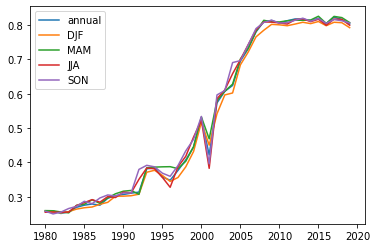

In [10]:
# plot fraction of stations that have more than 80% coverage per year
compete_station_frac = np.sum(obs_frac_season >= 0.8, axis= 2)/obs_frac_season.shape[2]
for se in range(len(seasons)):
    plt.plot(years, compete_station_frac[:,se], label = seasons[se])
plt.legend()

###  Read CONUS404 data
##### data comes from - papers/2022_Wind-Changes/programs/data_processing/uv10_data-processing.py

In [11]:
conus404_windspeed = save_dir + str(years[0]) + '-' + str(years[-1]) + '_CONUS404_stations_windspeed.npz'
ncid=Dataset('/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/wrfout_conus404_constants.nc', mode='r')
lon_wrf=np.squeeze(ncid.variables['XLONG'][:,:,lon_start:lon_stop])
lat_wrf=np.squeeze(ncid.variables['XLAT'][:,:,lon_start:lon_stop])
HGT_M = np.squeeze(ncid.variables['HGT'][:,:,lon_start:lon_stop])
LUI = np.squeeze(ncid.variables['LU_INDEX'][:,:,lon_start:lon_stop])
ncid.close()
lon_wrf[lon_wrf > 180] = lon_wrf[lon_wrf > 180]-360
metrics_foc = ['<1','mean','max']

if os.path.isfile(conus404_windspeed) == False:

    
    wrf_uv10_mean = np.zeros((len(years),12,lon_wrf.shape[0],lon_wrf.shape[1], len(metrics_foc)), dtype=np.float16); wrf_uv10_mean[:] = np.nan
    
    # nearest gridcell to station
    StationsInModel = np.zeros((len(LonST),2)); StationsInModel[:] = np.nan
    for st in range(len(LonST)):
        try:
            abslat = np.abs(lat_wrf-LatST[st])
            abslon= np.abs(lon_wrf-LonST[st])
            Loc = np.argmin(np.maximum(abslon,abslat))
            StationsInModel[st,:] = np.unravel_index(Loc, (lat_wrf.shape[0],lat_wrf.shape[1]))
        except:
            continue
    StationsInModel = StationsInModel.astype('int')
    
    # Data is preprocessed by running - papers/2022_Wind-Changes/programs/data_processing/uv10_data-processing.py
    wrf_uv10 = np.zeros((len(TimeHH),ST_DATA_windspeed.shape[1]), dtype=np.float16); wrf_uv10[:] = np.nan
    DataFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/uv10/'
    for yy in tqdm(range(len(years))):
        YYYY = years[yy]
        rgiHours = (TimeHH.year == YYYY) # & (TimeHH.month == MM)
        File_act = DataFolder + 'UV10_'+str(YYYY)+'_CONUS404.npz'
        data = np.load(File_act) # open the netcdf
        wrf_uv10[rgiHours,:] = data['wrf_uv10'][:,StationsInModel[:,0],StationsInModel[:,1]]
        wrf_uv10_mean[yy,:,:] = data['wrf_uv10_mean']

    np.savez(conus404_windspeed,
            TimeHH,TimeHH,
            LatST = LatST,
            LonST = LonST,
            HeigtST = HeigtST,
            wrf_uv10 = wrf_uv10,
            wrf_uv10_mean = wrf_uv10_mean,
            metrics_foc = metrics_foc)

else:
    data = np.load(conus404_windspeed)
    wrf_uv10 = data['wrf_uv10']
    wrf_uv10_mean = data['wrf_uv10_mean']

### Read daily extreme CONUS404 data

In [12]:
# we read wrfxtrm daily peak wind speeds here and calcualte monthly maxima
conus404_wrfxtrm = save_dir + str(years[0]) + '-' + str(years[-1]) + '_CONUS404_wrfxtrm-mon-peaks.npz'
if os.path.isfile(conus404_wrfxtrm) == False:
    wrf_wrfxtrm_mm = np.zeros((len(TimeMM), lon_wrf.shape[0], lon_wrf.shape[1])); wrf_wrfxtrm_mm[:] = np.nan
    for mm in tqdm(range(len(TimeMM))):
        YYYY = TimeMM[mm].year
        MM = TimeMM[mm].month
        if MM >= 10:
            WY = YYYY+1
        else:
            WY = YYYY
        dir_mm = '/glade/scratch/prein/tmp/CONUS404/WY'+str(WY)+'/'
        time_dd_act = TimeDD[(TimeDD.year == YYYY) & (TimeDD.month == MM)]
        wrf_mon_act = np.zeros((len(time_dd_act), lon_wrf.shape[0], lon_wrf.shape[1]))
        for hh in range(len(wrf_mon_act)):
            DD = time_dd_act[hh].day
            ncid=Dataset(dir_mm + 'wrfxtrm_d01_'+str(YYYY)+'-'+str(MM).zfill(2)+'-'+str(DD).zfill(2)+'_00:00:00', mode='r')
            U10MAX=np.squeeze(ncid.variables['U10MAX'][:,:,lon_start:lon_stop])
            V10MAX=np.squeeze(ncid.variables['V10MAX'][:,:,lon_start:lon_stop])
            ncid.close()
            wrf_mon_act[hh,:,:] = (U10MAX**2 + V10MAX**2)**0.5
        wrf_wrfxtrm_mm[mm,:,:] = np.max(wrf_mon_act[:], axis=0)
        
    np.savez(conus404_wrfxtrm,
            wrf_wrfxtrm_mm = wrf_wrfxtrm_mm,
            TimeMM = TimeMM,
            lon_wrf = lon_wrf,
            lat_wrf = lat_wrf)
else:
    data = np.load(conus404_wrfxtrm)
    wrf_wrfxtrm_mm = data['wrf_wrfxtrm_mm']
    wrf_wrfxtrm_mm = np.reshape(wrf_wrfxtrm_mm, (int(wrf_wrfxtrm_mm.shape[0]/12), 
                                                 12,
                                                 wrf_wrfxtrm_mm.shape[1],
                                                 wrf_wrfxtrm_mm.shape[2]))

In [13]:
# Get station values from montlhy extremes
# nearest gridcell to station
StationsInModel = np.zeros((len(LonST),2)); StationsInModel[:] = np.nan
for st in range(len(LonST)):
    try:
        abslat = np.abs(lat_wrf-LatST[st])
        abslon= np.abs(lon_wrf-LonST[st])
        Loc = np.argmin(np.maximum(abslon,abslat))
        StationsInModel[st,:] = np.unravel_index(Loc, (lat_wrf.shape[0],lat_wrf.shape[1]))
    except:
        continue
StationsInModel = StationsInModel.astype('int')
wrf_stat_mm_ext = wrf_wrfxtrm_mm[:,:,StationsInModel[:,0], StationsInModel[:,1]]

In [14]:
# calculate trends from wrfxtrm files
conus404_wrfxtrm_trend = save_dir + str(years[0]) + '-' + str(years[-1]) + '_CONUS404_wrfxtrm_JJA-trend.npz'
if os.path.isfile(conus404_wrfxtrm_trend) == False:
    wrf_uv10_extr_trends = np.zeros((lon_wrf.shape[0],lon_wrf.shape[1],len(seasons),5), dtype=np.float16); wrf_uv10_extr_trends[:] = np.nan
    for se in tqdm(range(len(seasons))):
        if se == 0:
            months = [0,1,2,3,4,5,6,7,8,9,10,11]
        elif se == 1:
            months = [0,1,11]
        if se == 2:
            months = [2,3,4]
        if se == 3:
            months = [5,6,7]
        if se == 4:
            months = [8,9,10]
        for la in range(lon_wrf.shape[0]):
            for lo in range(lon_wrf.shape[1]):
                data_act = np.max(wrf_wrfxtrm_mm[:,months,la,lo], axis=1)
                wrf_uv10_extr_trends[la,lo,se,:] = scipy.stats.linregress(years, data_act)
                wrf_uv10_extr_trends[la,lo,se,0] = wrf_uv10_extr_trends[la,lo,se,0]/np.mean(data_act)
    np.savez(conus404_wrfxtrm_trend,
            wrf_uv10_extr_trends = wrf_uv10_extr_trends,
            LatST = LatST,
            LonST = LonST,
            seasons=seasons)
else:
    data =np.load(conus404_wrfxtrm_trend)
    wrf_uv10_extr_trends = data['wrf_uv10_extr_trends']

### Calculate wind speed trends


In [15]:
conus404_windtrends = save_dir + str(years[0]) + '-' + str(years[-1]) + '_CONUS404_grid-trends.npz'
seasons = ['annual','DJF','MAM','JJA','SON']
if os.path.isfile(conus404_windtrends) == False:
    wrf_uv10_trends = np.zeros((lon_wrf.shape[0],lon_wrf.shape[1], len(metrics),len(seasons),5), dtype=np.float16); wrf_uv10_trends[:] = np.nan
    for se in tqdm(range(len(seasons))):
        if se == 0:
            months = [0,1,2,3,4,5,6,7,8,9,10,11]
        elif se == 1:
            months = [0,1,11]
        if se == 2:
            months = [2,3,4]
        if se == 3:
            months = [5,6,7]
        if se == 4:
            months = [8,9,10]
        for la in tqdm(range(lon_wrf.shape[0])):
            for lo in range(lon_wrf.shape[1]):
                for me in range(len(metrics)):
                    if metrics[me] == 'max':
                        data_act = np.max(wrf_uv10_mean[:,months,la,lo,me], axis=1)
                    else:
                        data_act = np.mean(wrf_uv10_mean[:,months,la,lo,me], axis=1)
                    wrf_uv10_trends[la,lo,me,se,:] = scipy.stats.linregress(years, data_act)
                    wrf_uv10_trends[la,lo,me,se,0] = wrf_uv10_trends[la,lo,me,se,0]/np.mean(data_act)
    np.savez(conus404_windtrends,
            wrf_uv10_trends = wrf_uv10_trends,
            LatST = LatST,
            LonST = LonST,
            metrics = metrics,
            seasons=seasons)
else:
    data =np.load(conus404_windtrends)
    wrf_uv10_trends = data['wrf_uv10_trends']

### Read ERA5 data

In [16]:
era5_windspeed = save_dir + str(years[0]) + '-' + str(years[-1]) + '_ERA5_stations_windspeed.npz'
if os.path.isfile(era5_windspeed) == False:
    era_var = ['u10','v10']
    REGION = [np.max(lat_wrf),np.max(lon_wrf),np.min(lat_wrf),np.min(lon_wrf)]
    era_u10 = ReadERA5(TimeHH,      # Time period to read (this program will read hourly data)
                        era_var[0],        # Variable name. See list below for defined variables
                        -1,         # Pressure level of variable
                        REGION)    # Region to read. Format must be <[N,E,S,W]> in degrees from -180 to +180 longitude
    era_v10 = ReadERA5(TimeHH,      # Time period to read (this program will read hourly data)
                        era_var[1],        # Variable name. See list below for defined variables
                        -1,         # Pressure level of variable
                        REGION)    # Region to read. Format must be <[N,E,S,W]> in degrees from -180 to +180 longitude
    era_uv10 = (era_u10[0]**2 + era_v10[0]**2)**0.5
    
    np.savez(era5_windspeed,
            TimeHH,TimeHH,
            LatST = LatST,
            LonST = LonST,
            HeigtST = HeigtST,
            era_uv10 = era_uv10,
            lon_era = era_v10[2],
            lat_era = era_v10[1])
else:
    data = np.load(era5_windspeed)
    era_uv10 = data['era_uv10']
    lon_era = data['lon_era']
    lat_era = data['lat_era']

In [17]:
# get stations data from ERA5
# get the location of the stations
# nearest gridcell to station
lon_era = np.array(lon_era, dtype=np.float16)
lat_era = np.array(lat_era, dtype=np.float16)
StationsInModel = np.zeros((len(LonST),2)); StationsInModel[:] = np.nan
for st in range(len(LonST)):
    try:
        abslat = np.abs(lat_era-LatST[st])
        abslon= np.abs(lon_era-LonST[st])
        Loc = np.argmin(np.maximum(abslon,abslat))
        StationsInModel[st,:] = np.unravel_index(Loc, (lon_era.shape[0],lon_era.shape[1]))
    except:
        continue
StationsInModel = StationsInModel.astype('int')
era_uv10_st = era_uv10[:,StationsInModel[:,0],StationsInModel[:,1]]

In [18]:
### Calculate trends in ERA5 wind speed
era_windtrends = save_dir + str(years[0]) + '-' + str(years[-1]) + '_ERA_grid-trends.npz'
seasons = ['annual','DJF','MAM','JJA','SON']
if os.path.isfile(era_windtrends) == False:
    # calculate monthly statistics
    metrics = ['<1','mean','max']
    era_uv10_mean = np.zeros((len(years), 12,lon_era.shape[0],lon_era.shape[1], len(metrics)), dtype=np.float16); era_uv10_mean[:] = np.nan

    for yy in tqdm(range(len(years))):
        for mm in range(12):
            time_sel = np.isin(TimeHH.month, [mm+1]) & (TimeHH.year == years[yy])
            data_mm = era_uv10[time_sel,:,:]
            for me in range(len(metrics)):
                if metrics[me] == '<1':
                    era_uv10_mean[yy,mm,:,:,me] = np.nansum(data_mm[:,:,:] < 1, axis=0)/np.nansum(time_sel)
                elif metrics[me] == 'mean':
                    era_uv10_mean[yy,mm,:,:,me] = np.nanmean(data_mm[:,:,:], axis=0)
                elif metrics[me] == 'max':
                    era_uv10_mean[yy,mm,:,:,me] = np.nanmax(data_mm[:,:,:], axis=0)
                else:
                    continue

    era_uv10_trends = np.zeros((lon_era.shape[0],lon_era.shape[1], len(metrics),len(seasons),5), dtype=np.float16); era_uv10_trends[:] = np.nan
    for se in tqdm(range(len(seasons))):
        if se == 0:
            months = [0,1,2,3,4,5,6,7,8,9,10,11]
        elif se == 1:
            months = [0,1,11]
        if se == 2:
            months = [2,3,4]
        if se == 3:
            months = [5,6,7]
        if se == 4:
            months = [8,9,10]
                    
        for la in range(lon_era.shape[0]):
            for lo in range(lon_era.shape[1]):
                for me in range(len(metrics)):
                    if metrics[me] == 'max':
                        data_act = np.max(era_uv10_mean[:,months,la,lo,me], axis=1)
                    else:
                        data_act = np.mean(era_uv10_mean[:,months,la,lo,me], axis=1)
                    era_uv10_trends[la,lo,me,se,:] = scipy.stats.linregress(years, data_act)
                    era_uv10_trends[la,lo,me,se,0] = era_uv10_trends[la,lo,me,se,0]/np.mean(data_act)
    np.savez(era_windtrends,
            era_uv10_mean = era_uv10_mean,
            era_uv10_trends = era_uv10_trends,
            lat_era = lat_era,
            lon_era = lon_era,
            metrics = metrics,
            years =years,
            seasons = seasons)
else:
    data =np.load(era_windtrends)
    era_uv10_trends = data['era_uv10_trends']
    era_uv10_mean = data['era_uv10_mean']

In [19]:
# remove records that have less than 80 % of the data for more than 20 % of the years
compete_station_frac_yy = np.sum(obs_frac_season >= 0.8, axis= 0)/obs_frac_season.shape[0]

st_complete = np.copy(ST_DATA_windspeed[:,compete_station_frac_yy[0,:] >= 0.8 ])
wrf_complete = np.copy(wrf_uv10[:,compete_station_frac_yy[0,:] >= 0.8 ])
era_complete = np.copy(era_uv10_st[:,compete_station_frac_yy[0,:] >= 0.8 ])

lon_comp = np.copy(LonST[compete_station_frac_yy[0,:] >= 0.8])
lat_comp = np.copy(LatST[compete_station_frac_yy[0,:] >= 0.8])

NaN = np.isnan(st_complete)
wrf_complete[NaN] = np.nan
era_complete[NaN] = np.nan

### get stations in subregions

In [20]:
import geopandas as gpd
REGIONS = ['Gulf-Atlantic_coast.shp','Westcoast.shp','Front-Range.shp', 'Intermauntain-west.shp','Central_US.shp']#'Derecho_hotspot.shp'] #'Midwest.shp',
reg_colors = ['#1f78b4','#33a02c','#e31a1c','#ff7f00','#6a3d9a','#b2df8a']
Reg_Poly = {}
MaskStations = np.zeros((lat_comp.shape[0]))
rgrGridCells=[(lon_comp.flatten()[ii],lat_comp.flatten()[ii]) for ii in range(len(lat_comp.flatten()))]
for re in tqdm(range(len(REGIONS))):
    data = gpd.read_file('/glade/u/home/prein/papers/2022_Wind-Changes/shapefiles/'+REGIONS[re])
    Coordinates = data['geometry']
    sf = 0
    TEST = np.array(Coordinates[sf].exterior.coords.xy)
    ctr=TEST.T
    Reg_Poly[REGIONS[re]] = ctr
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    TMP = np.reshape(TMP, (lat_comp.shape[0]))
    MaskStations[TMP==1] = re+1
#     MaskStations = np.append(MaskStations,[re+1]*len(iStationSelect))
MaskStations = MaskStations.astype('int')
    
MaskStations[MaskStations < 0] = 0

Region_indices = ndimage.find_objects(MaskStations)
# Region_indices = ndimage.find_objects(MaskStations)

100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


In [21]:
### regions in C-404 grid
MaskStations_wrf = np.zeros((lat_wrf.shape[0],lat_wrf.shape[1]))
# rgrGridCells=[(lon_wrf.flatten()[ii],lat_wrf.flatten()[ii]) for ii in range(len(lat_wrf.flatten()))]
rgrGridCells = np.append(lon_wrf.flatten()[:,None],lat_wrf.flatten()[:,None], axis=1)
for re in tqdm(range(len(REGIONS))):
    data = gpd.read_file('/glade/u/home/prein/papers/2022_Wind-Changes/shapefiles/'+REGIONS[re])
    Coordinates = data['geometry']
    sf = 0
    TEST = np.array(Coordinates[sf].exterior.coords.xy)
    ctr=TEST.T
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    TMP = np.reshape(TMP, (lat_wrf.shape[0], lat_wrf.shape[1]))
    MaskStations_wrf[TMP==1] = re+1
#     MaskStations = np.append(MaskStations,[re+1]*len(iStationSelect))
MaskStations_wrf = MaskStations_wrf.astype('int')
    
MaskStations_wrf[MaskStations_wrf < 0] = 0

100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


In [22]:
### regions in C-404 grid
MaskStations_era = np.zeros((lat_era.shape[0],lat_era.shape[1]))
# rgrGridCells=[(lon_era.flatten()[ii],lat_era.flatten()[ii]) for ii in range(len(lat_era.flatten()))]
rgrGridCells = np.append(lon_era.flatten()[:,None],lat_era.flatten()[:,None], axis=1)
for re in tqdm(range(len(REGIONS))):
    data = gpd.read_file('/glade/u/home/prein/papers/2022_Wind-Changes/shapefiles/'+REGIONS[re])
    Coordinates = data['geometry']
    sf = 0
    TEST = np.array(Coordinates[sf].exterior.coords.xy)
    ctr=TEST.T
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    TMP = np.reshape(TMP, (lat_era.shape[0], lat_era.shape[1]))
    MaskStations_era[TMP==1] = re+1
#     MaskStations = np.append(MaskStations,[re+1]*len(iStationSelect))
MaskStations_era = MaskStations_era.astype('int')
    
MaskStations_era[MaskStations_era < 0] = 0

100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


### Bin the wind speed data to the observational accuracy

In [23]:
data_stations = np.array(
                np.append(
                np.append(st_complete[:,:,None],era_complete[:,:,None], axis=2), 
                          wrf_complete[:,:,None], axis=2),
                dtype=np.float32)

In [24]:
### Coarsen the dataset to account for changes in wind bins over time
bined_st_dat = save_dir + str(years[0]) + '-' + str(years[-1]) + '_Bined-station-data.npz'
if os.path.isfile(bined_st_dat) == False:
    wind_bins = np.array([0,1.5] + list(np.arange(1.5,100,0.5)))

    data_stations_bin = np.copy(data_stations); data_stations_bin[:] = np.nan
    # test = np.array(wind_bins[(np.abs(data_stations[:,0,0] - wind_bins[:,None,None]) < const).argmax(0)])[0]
    for st in tqdm(range(data_stations.shape[1])):
        for da in range(data_stations.shape[2]):
            data_tmp = data_stations[:,st,da]
            NAN = np.isnan(data_tmp)
            bin_data = np.array(wind_bins[(np.abs(data_stations[:,st,da] - wind_bins[:,None,None])).argmin(0)])[0]
            bin_data[NAN] = np.nan
            data_stations_bin[:,st,da] = bin_data
    np.savez(bined_st_dat,
            data_stations_bin = data_stations_bin,
            wind_bins = wind_bins,
            LatST = LatST,
            LonST = LonST,
            TimeHH = TimeHH)
else:
    data = np.load(bined_st_dat)
    data_stations_bin = data['data_stations_bin']


In [25]:
### Calculate trends in station wind speed
sta_windtrends = save_dir + str(years[0]) + '-' + str(years[-1]) + '_Station_grid-trends.npz'
seasons = ['annual','DJF','MAM','JJA','SON']
if os.path.isfile(sta_windtrends) == False:
    # calculate monthly statistics
    metrics = ['<1','mean','max']
    sta_uv10_mean = np.zeros((len(years), 12, data_stations_bin.shape[1], data_stations_bin.shape[2], len(metrics)), dtype=np.float16); sta_uv10_mean[:] = np.nan

    for yy in tqdm(range(len(years))):
        for mm in range(12):
            for da in range(data_stations_bin.shape[2]):
                time_sel = np.isin(TimeHH.month, [mm+1]) & (TimeHH.year == years[yy])
                data_mm = data_stations[time_sel,:,:]
                data_mm[data_mm <= 3] = np.nan
                for me in range(len(metrics)):
                    if metrics[me] == '<1':
                        sta_uv10_mean[yy,mm,:,da,me] = np.nansum(data_mm[:,:,da] < 1, axis=0)/np.nansum(time_sel)
                    elif metrics[me] == 'mean':
                        sta_uv10_mean[yy,mm,:,da,me] = np.nanmean(data_mm[:,:,da], axis=0)
                    elif metrics[me] == 'max':
                        sta_uv10_mean[yy,mm,:,da,me] = np.nanmax(data_mm[:,:,da], axis=0)
                    else:
                        continue

    # add wrf_stat_mm_ext to trend analysis
    temp_data = wrf_stat_mm_ext[:,:,(compete_station_frac_yy[0,:] >= 0.8),None]
    temp_data = np.repeat(temp_data[:,:,:,:,np.newaxis], 3, axis=4)
    temp_data[:,:,:,:,1:] = np.nan
    sta_uv10_mean = np.append(sta_uv10_mean, temp_data, axis=3)

    sta_uv10_trends = np.zeros((data_stations_bin.shape[1],data_stations_bin.shape[2], len(metrics),len(seasons),5), dtype=np.float16); sta_uv10_trends[:] = np.nan
    for se in tqdm(range(len(seasons))):
        if se == 0:
            months = [0,1,2,3,4,5,6,7,8,9,10,11]
        elif se == 1:
            months = [0,1,11]
        if se == 2:
            months = [2,3,4]
        if se == 3:
            months = [5,6,7]
        if se == 4:
            months = [8,9,10]
        for st in tqdm(range(data_stations_bin.shape[1])):
            for da in range(data_stations_bin.shape[2]):
                for me in range(len(metrics)):
                    if metrics[me] == 'max':
                        data_act = np.nanmax(sta_uv10_mean[:,months,st,da,me], axis=1)
                    else:
                        data_act = np.nanmean(sta_uv10_mean[:,months,st,da,me], axis=1)
                    FIN = ~np.isnan(data_act)
                    sta_uv10_trends[st,da,me,se,:] = scipy.stats.linregress(years[FIN], data_act[FIN])
                    sta_uv10_trends[st,da,me,se,0] = sta_uv10_trends[st,da,me,se,0]/np.nanmean(data_act)
    np.savez(sta_windtrends,
            sta_uv10_mean = sta_uv10_mean,
            sta_uv10_trends = sta_uv10_trends,
            LatST = LatST,
            LonST = LonST,
            metrics = metrics,
            years =years,
            seasons = seasons)
else:
    data =np.load(sta_windtrends)
    sta_uv10_trends = data['sta_uv10_trends']
    sta_uv10_mean = data['sta_uv10_mean']

### CALCULATE TRENDS ON COARSE GRID

In [26]:
# Here we average the data first and then calculate trends on the averaged time series
lon_bin = np.arange(-120,-60,3); lon_binc = (lon_bin[1:] + lon_bin[:-1])/2
lat_bin = np.arange(20,55,3); lat_binc = (lat_bin[1:] + lat_bin[:-1])/2
coarse_grained_data = np.zeros((sta_uv10_mean.shape[0], 
                                sta_uv10_mean.shape[1],
                                len(lat_binc),
                                len(lon_binc),
                                sta_uv10_mean.shape[3],
                                sta_uv10_mean.shape[4])); coarse_grained_data[:] = np.nan
for da in range(3):
    if da == 0:
        data_act = sta_uv10_mean[:,:,:,0,:]
        lon_act = lon_comp
        lat_act = lat_comp
    if da == 1:
        data_act = np.reshape(era_uv10_mean, (era_uv10_mean.shape[0],
                                              era_uv10_mean.shape[1],
                                              era_uv10_mean.shape[2] * era_uv10_mean.shape[3],
                                              era_uv10_mean.shape[4]))
        lon_act = lon_era.flatten()
        lat_act = lat_era.flatten()
    if da == 2:
        data_act = np.array(np.reshape(wrf_uv10_mean, (wrf_uv10_mean.shape[0],
                                              wrf_uv10_mean.shape[1],
                                              wrf_uv10_mean.shape[2] * wrf_uv10_mean.shape[3],
                                              wrf_uv10_mean.shape[4])), dtype=np.float32)
        lon_act = lon_wrf.flatten()
        lat_act = lat_wrf.flatten()
    for la in range(len(lat_bin)-1):
        for lo in range(len(lon_bin)-1):
            stations_in_grid = (lon_act >= lon_bin[lo]) & \
                               (lon_act < lon_bin[lo+1]) & \
                               (lat_act >= lat_bin[la]) & \
                               (lat_act < lat_bin[la+1])
            if np.sum(stations_in_grid) >= 2:
                coarse_grained_data[:,:,la,lo,da,:] = np.nanmean(data_act[:,:,stations_in_grid,:], axis=2)


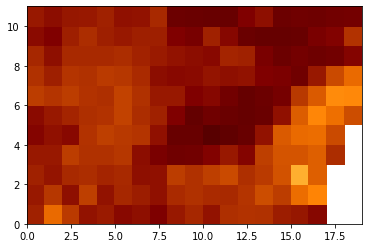

In [27]:
plt.pcolormesh(coarse_grained_data[39,7,:,:,2,2], cmap='afmhot', vmin=0,vmax=35)

In [28]:
lon_act.shape

(1386490,)

        Plot map to: Aug_2019_houlry-peak-wind-speed.jpg


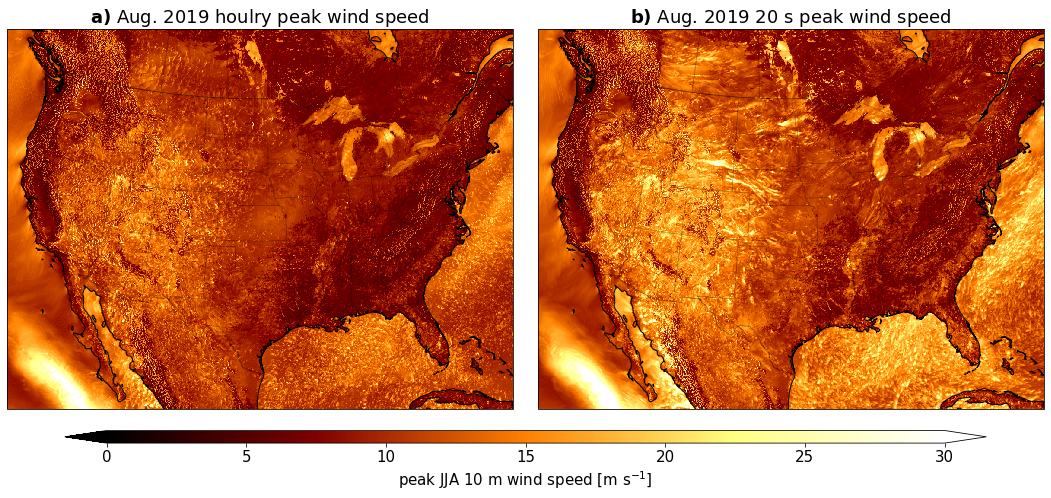

In [29]:
fig = plt.figure(figsize=(16,7))
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.05, right=0.95,
   bottom=0.1, top=0.95,
   wspace=0.05, hspace=0.3)
plt.rcParams.update({'font.size': 15})

ax = plt.subplot(gs1[0,0], projection=cart_proj)
plt.pcolormesh(lon_wrf,lat_wrf,wrf_uv10_mean[38,7,:,:,2], cmap='afmhot', vmin=0,vmax=30, transform=ccrs.PlateCarree())
ax.coastlines(zorder = 20)
ax.add_feature(cf.BORDERS, alpha=0.25, zorder = 20)
ax.add_feature(cf.STATES, lw=0.5, alpha=0.25, zorder = 20)
ax.set_extent([-120, -75, 23, 53], crs=ccrs.PlateCarree())
plt.title(r"$\bf{" + rgsLableABC[0] + ")}$"+' Aug. 2019 houlry peak wind speed')


ax = plt.subplot(gs1[0,1], projection=cart_proj)
sc = plt.pcolormesh(lon_wrf,lat_wrf,wrf_wrfxtrm_mm[38,7,:,:], cmap='afmhot', vmin=0,vmax=30, transform=ccrs.PlateCarree())
ax.coastlines(zorder = 20)
ax.add_feature(cf.BORDERS, alpha=0.25, zorder = 20)
ax.add_feature(cf.STATES, lw=0.5, alpha=0.25, zorder = 20)
ax.set_extent([-120, -75, 23, 53], crs=ccrs.PlateCarree())
plt.title(r"$\bf{" + rgsLableABC[1] + ")}$"+' Aug. 2019 20 s peak wind speed')

CbarAx = axes([0.1, 0.08, 0.8, 0.025])
cb = colorbar(sc, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('peak JJA 10 m wind speed [m s$^{-1}$]', fontsize=15)

sPlotFile=''
sPlotName= 'Aug_2019_houlry-peak-wind-speed.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=350)

In [30]:
annual_max_stations = np.zeros((len(years), 5, data_stations.shape[1], data_stations.shape[2]))
for yy in tqdm(range(len(years))):
    for se in range(5):
        if se == 0:
            months = [1,2,3,4,5,6,7,8,9,10,11,12]
        elif se == 1:
            months = [1,2,12]
        if se == 2:
            months = [3,4,5]
        if se == 3:
            months = [6,7,8]
        if se == 4:
            months = [9,10,11]
        time_sel = (TimeHH.year == years[yy]) & np.isin(TimeHH.month, months)
        annual_max_stations[yy, se,:,:] = np.nanmax(data_stations[time_sel,:,:], axis=0)

100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


### Calculate annual time series of metrics

In [31]:
moveav = 30 # day window
annual_metrics = np.zeros((len(years), 12, data_stations.shape[1], data_stations.shape[2], len(metrics_ext)))
for yy in tqdm(range(len(years))):
    for mm in range(12):
        mm0 = mm
        mm1 = mm + 1
        mm2 = mm + 2
        if mm0 == 0:
            mm0 = 12
        if mm2 == 13:
            mm2 = 1
        time_sel = (TimeHH.year == years[yy]) & np.isin(TimeHH.month, [mm0,mm1,mm2])
        data_year = data_stations_bin[time_sel,:,:]
        for me in range(len(metrics_ext)):
            if metrics_ext[me] == '<1':
                annual_metrics[yy, mm,:,:,me] = np.nansum(data_year[:,:,:] < 1.5, axis=0)/np.nansum(~np.isnan(data_year[:,:,:]), axis=0)
            elif metrics_ext[me] == 'mean':
                annual_metrics[yy, mm,:,:,me] = np.nanmean(data_year[:,:,:], axis=0)
            elif metrics_ext[me] == 'max':
                annual_metrics[yy, mm,:,:,me] = np.nanmax(data_year[:,:,:], axis=0)
            else:
                annual_metrics[yy, mm,:,:,me] = np.nanpercentile(data_year[:,:,:], metrics_ext[me],axis=0)

100%|██████████| 40/40 [07:07<00:00, 10.70s/it]


In [32]:
# add wrf extreme data
tmp_data = sta_uv10_mean[:,:,:,[3],0]
annual_metrics = np.append(annual_metrics, np.repeat(tmp_data[:,:,:,:,np.newaxis], 7, axis=4), axis=3)

In [33]:
### calculate trends in the monthly statistics
trends_months = np.zeros((12, len(REGIONS), annual_metrics.shape[3], len(metrics_ext), 5))
FIN = (years != 1900) #(years != 1997)
for mm in tqdm(range(12)):
    for me in range(len(metrics_ext)):
        data_act = annual_metrics[FIN,mm,:,:,me]
        for re in range(len(REGIONS)):
            reg_sel = MaskStations == (re+1)
            data_reg = np.nanmedian(data_act[:,reg_sel,:], axis=1)
            for da in range(4):
                trends_months[mm, re, da,me,:] = scipy.stats.linregress(years[FIN], data_reg[:,da])
                trends_months[mm, re, da,me,0] = (trends_months[mm, re, da, me, 0])/np.mean(data_reg[:,da])
                trends_months[mm, re, da,me,4] = (trends_months[mm, re, da, me, 4])/np.mean(data_reg[:,da])


100%|██████████| 12/12 [00:01<00:00,  7.51it/s]


In [34]:
### Calculate linear trend estimates
lin_trend_max = np.zeros((5, data_stations.shape[1], data_stations.shape[2], 5))
lin_trend_mean = np.zeros((5, data_stations.shape[1], data_stations.shape[2], 5))
for se in tqdm(range(5)):
    for da in range(annual_max_stations.shape[3]):
        for st in range(annual_max_stations.shape[2]):
            data_tmp = annual_max_stations[:, se,st,da]
            FIN = (~np.isnan(data_tmp)) & (years != 1997) & (years != 1998)
            lin_trend_max[se, st, da,:] = scipy.stats.linregress(years[FIN], data_tmp[FIN])
            lin_trend_max[se, st, da,0] = (lin_trend_max[se, st, da,0])/np.mean(data_tmp[FIN])
            
            
            lin_trend_max[se, st, da,:] = scipy.stats.linregress(years[FIN], data_tmp[FIN])
            lin_trend_max[se, st, da,0] = (lin_trend_max[se, st, da,0])/np.mean(data_tmp[FIN])

100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


<AxesSubplot:ylabel='Density'>

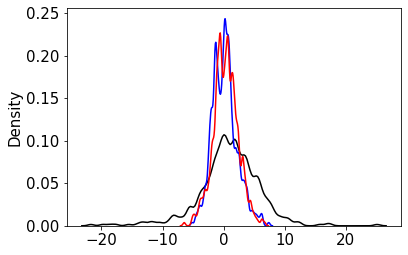

In [35]:
# sns.kdeplot(ST_DATA_windspeed[ST_DATA_windspeed[:,st]>0,st].flatten(), cut=0, c='k', bw=0.1)
se = 3
st = 2
# sta_uv10_trends[st,da,me,se,:]
FIN = ~np.isnan(sta_uv10_trends[:,0,st,se,0])
sns.kdeplot(sta_uv10_trends[:,0,st,se,0][FIN].flatten()*1000, c='k', bw=0.1)
sns.kdeplot(sta_uv10_trends[:,1,st,se,0][FIN].flatten()*1000, c='b', bw=0.1)
sns.kdeplot(sta_uv10_trends[:,2,st,se,0][FIN].flatten()*1000, c='r', bw=0.1)

### Plot mean and annual maximum windspeed on map

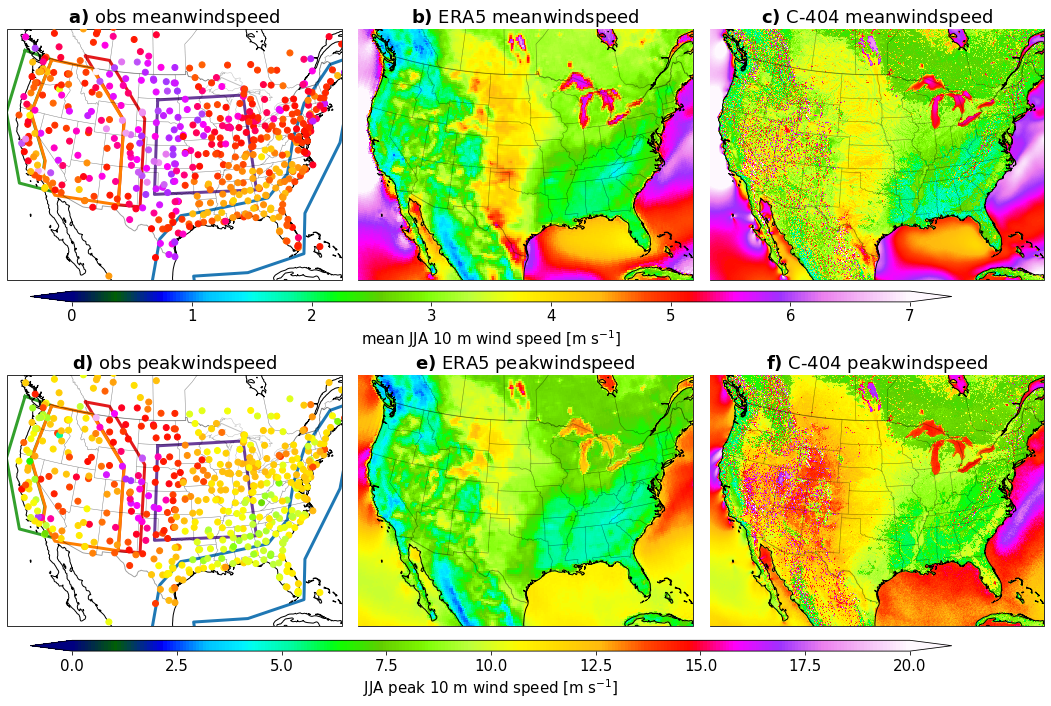

In [36]:
se=0
fig = plt.figure(figsize=(16,10))
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.05, hspace=0.3)
plt.rcParams.update({'font.size': 15})

prominence = scipy.ndimage.gaussian_filter(HGT_M,2.5)\
            - scipy.ndimage.gaussian_filter(HGT_M,10)

datasets = ['obs', 'ERA5', 'C-404']
stat_name = ['mean','peak']
cmap = 'gist_ncar'
stat_sel = [1,2]
JJA = [5,6,7]
for st in range(2):
    if st == 0:
        col_range = [0,7]
    elif st == 1:
        col_range = [0,20]
    for da in range(3): #range(lin_trend_max.shape[2]):
        if da == 1:
            data_act = era_uv10_mean[:,JJA]
            lon_act = lon_era
            lat_act = lat_era
        elif da == 2:
            data_act = wrf_uv10_mean[:,JJA]
            lon_act = lon_wrf
            lat_act = lat_wrf

        ax = plt.subplot(gs1[st,da], projection=cart_proj)
        for re in range(len(REGIONS)):
            plt.plot(Reg_Poly[REGIONS[re]][:,0], Reg_Poly[REGIONS[re]][:,1], c=reg_colors[re], 
                     lw=3, transform=ccrs.PlateCarree(), zorder = 1)

        clevs = np.arange(0,3600,200)
        #Load ColorMap
        from ExternalFunctions import gmtColormap
        rgrColMap=gmtColormap(GMTPath='/glade/u/home/prein/MyPython_Programs/python/ColorMaps/', fileName='DEM_screen')
        blue_red1 = LinearSegmentedColormap('BlueRed1', rgrColMap)

#         plt.contour(Lon4, Lat4, prominence, 
#                     transform=ccrs.PlateCarree(), 
#                     levels=[200,9999], colors=['gray','gray'], alpha=0.75, zorder = 25)

        if (da != 0):
            plt.pcolormesh(lon_act,lat_act, np.mean(data_act[:,:,:,:,stat_sel[st]], axis=(0,1)),  
                       cmap = cmap, vmin=col_range[0], vmax=col_range[1], transform=ccrs.PlateCarree(), zorder = 15)
        else:
        # plot station data on top of contour
            sc = plt.scatter(lon_comp,lat_comp, c=np.nanmean(sta_uv10_mean[:,:,:,da,stat_sel[st]], axis=(0,1)), vmin=col_range[0], vmax=col_range[1], 
                        cmap=cmap, transform=ccrs.PlateCarree(), zorder = 30)

        plt.title(r"$\bf{" + rgsLableABC[da+st*3] + ")}$"+' ' + datasets[da] + ' ' + stat_name[st] + 'windspeed')


        ax.coastlines(zorder = 20)
        ax.add_feature(cf.BORDERS, alpha=0.25, zorder = 20)
        ax.add_feature(cf.STATES, lw=0.5, alpha=0.25, zorder = 20)
        ax.set_extent([-120, -75, 23, 53], crs=ccrs.PlateCarree())
    #     gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    #     gl.left_labels = False

    if st == 0:
        CbarAx = axes([0.1, 0.56, 0.8, 0.015])
        cb = colorbar(sc, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
        # cb.ax.set_xticklabels(LEVS,rotation=90)
        cb.set_label('mean JJA 10 m wind speed [m s$^{-1}$]', fontsize=15)
    else:
        CbarAx = axes([0.1, 0.075, 0.8, 0.015])
        cb = colorbar(sc, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
        # cb.ax.set_xticklabels(LEVS,rotation=90)
        cb.set_label('JJA peak 10 m wind speed [m s$^{-1}$]', fontsize=15)

        
        



In [37]:
### Load data for Aug 10 2020 Iowa Tornado
time_case=pd.date_range(datetime.datetime(2020, 8, 1,0), end=datetime.datetime(2020, 8, 31,23), freq='h')

tt_inmonth = 237

ncid=Dataset('/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/MLCAPE/MLCAPE_202008_CONUS404.nc', mode='r') # open the netcdf
CAPE=np.squeeze(ncid.variables['MLCAPE'][tt_inmonth,:,:])
ncid.close()
ncid=Dataset('/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/U10/U10_202008_CONUS404.nc', mode='r') # open the netcdf
U10=np.squeeze(ncid.variables['U10'][tt_inmonth,:,:])
ncid.close()
ncid=Dataset('/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/V10/V10_202008_CONUS404.nc', mode='r') # open the netcdf
V10=np.squeeze(ncid.variables['V10'][tt_inmonth,:,:])
ncid.close()
UV10 = (U10**2 + V10**2)**0.5
ncid=Dataset('/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/REFL_10CM/REFL_10CM_202008_CONUS404.nc', mode='r') # open the netcdf
REFL_10CM=np.squeeze(ncid.variables['REFL_10CM'][tt_inmonth,:,:])
ncid.close()
ncid=Dataset('/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/cold_pool_intensity/202008_Cold-Pool-Intensity.nc', mode='r') # open the netcdf
coldpool_int=np.squeeze(ncid.variables['coldpoolint'][tt_inmonth,:,:])
ncid.close()


In [38]:
### Read ERA5 Data
ncid=Dataset("/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc", mode='r')
Lat_F=np.squeeze(ncid.variables['latitude'][:])
Lon_F=np.squeeze(ncid.variables['longitude'][:])
# Zfull=np.squeeze(ncid.variables['Z'][:])
ncid.close()
if np.max(Lon_F) > 180:
    Lon_F[Lon_F >= 180] = Lon_F[Lon_F >= 180] - 360
Lon_F,Lat_F = np.meshgrid(Lon_F,Lat_F)

ncid=Dataset('/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/202008/e5.oper.an.sfc.128_059_cape.ll025sc.2020080100_2020083123.nc', mode='r') # open the netcdf
CAPE_E=np.squeeze(ncid.variables['CAPE'][tt_inmonth,:,:])
ncid.close()
ncid=Dataset('/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/202008/e5.oper.an.sfc.228_131_u10n.ll025sc.2020080100_2020083123.nc', mode='r') # open the netcdf
U10_E=np.squeeze(ncid.variables['U10N'][tt_inmonth,:,:])
ncid.close()
ncid=Dataset('/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/202008/e5.oper.an.sfc.228_132_v10n.ll025sc.2020080100_2020083123.nc', mode='r') # open the netcdf
V10_E=np.squeeze(ncid.variables['V10N'][tt_inmonth,:,:])
ncid.close()
UV10_E = (U10_E**2 + V10_E**2)**0.5

# Calculate ERA5 reflectivity
ncid=Dataset('/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202008/e5.oper.an.pl.128_130_t.ll025sc.2020081000_2020081023.nc', mode='r') # open the netcdf
T_E=np.squeeze(ncid.variables['T'][20,:,:])
ncid.close()
ncid=Dataset('/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202008/e5.oper.an.pl.128_133_q.ll025sc.2020081000_2020081023.nc', mode='r') # open the netcdf
Q_E=np.squeeze(ncid.variables['Q'][20,:,:])
ncid.close()
level = np.array([ 1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 
    250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 
    850, 875, 900, 925, 950, 975, 1000])*100.
P_E = np.copy(Q_E)
P_E[:,:,:] = level[:, None, None]
ncid=Dataset('/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202008/e5.oper.an.pl.128_246_clwc.ll025sc.2020081000_2020081023.nc', mode='r') # open the netcdf
CL_E=np.squeeze(ncid.variables['CLWC'][20,:,:])
ncid.close()
ncid=Dataset('/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202008/e5.oper.an.pl.128_247_ciwc.ll025sc.2020081000_2020081023.nc', mode='r') # open the netcdf
CI_E=np.squeeze(ncid.variables['CIWC'][20,:,:])
ncid.close()
import wrf
Z_E = wrf.dbz(P_E, T_E, Q_E, CL_E,qs=CI_E)
Z_E = np.nanmax(Z_E, axis=0)


# # calcualte cold pool intensity
ThetaK = T_E* (100000/P_E)**0.286
ThetaP = ThetaK * (1 + 0.608 * Q_E - CL_E - CI_E)
AvArea=int(100000/25000)
ThetaP_mean=scipy.ndimage.uniform_filter(ThetaP[:,:,:],[0,AvArea,AvArea])
Boyancy=(9.81*(ThetaP-ThetaP_mean))/ThetaP_mean

# calculate cold-pool intensity (B)
bin_boy = Boyancy < -0.005
cooldpool_z_depth = (bin_boy[:,:,:]!=1).argmax(axis=0)

ncid=Dataset('/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202008/e5.oper.an.pl.128_129_z.ll025sc.2020081000_2020081023.nc', mode='r') # open the netcdf
ZG_E=np.squeeze(ncid.variables['Z'][20,:,:])
ncid.close()

delta_z = ZG_E[1:,:,:] - ZG_E[:-1,:,:]

integral_cp_z = np.array(delta_z) * np.squeeze(Boyancy[:-1])
CPI_E = np.zeros((integral_cp_z.shape[1],integral_cp_z.shape[2]))
for la in range(integral_cp_z.shape[1]):
    for lo in range(integral_cp_z.shape[2]):
        if int(cooldpool_z_depth[la,lo]) != 0:
            CPI_E[la,lo] = np.array((np.sum(integral_cp_z[:int(cooldpool_z_depth[la,lo]),la,lo], axis=0)*-2)**0.5)

### Plot straight line wind storm case and show statistics for Derecho Hotspot

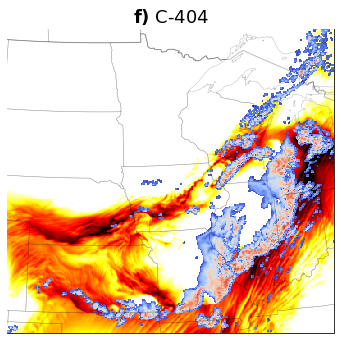

In [39]:
fig = plt.figure(figsize=(16,7))
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.1, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.05, hspace=0.3)

ax = plt.subplot(gs1[0,0], projection=cart_proj)
re = REGIONS.index('Central_US.shp')
plt.plot(Reg_Poly[REGIONS[re]][:,0], Reg_Poly[REGIONS[re]][:,1], c=reg_colors[re], 
         lw=3, transform=ccrs.PlateCarree(), zorder = 1)


# CAPE
plt.pcolormesh(lon_wrf,lat_wrf, CAPE[:,:-1],  
           cmap = 'hot_r', vmin=500, vmax=3500, transform=ccrs.PlateCarree(), zorder = 15)

# # Wind speed
# wind = np.copy(UV10[:,:-1])
# wind = np.ma.masked_array(wind, wind < 7)
# plt.pcolormesh(lon_wrf,lat_wrf, wind,  
#            cmap = 'coolwarm_r', vmin=0, vmax=10, transform=ccrs.PlateCarree(), zorder = 15, alpha=0.5)

# Reflectivity
Z = np.copy(REFL_10CM[:,:-1])
Z = np.ma.masked_array(Z, Z < 0)
plt.pcolormesh(lon_wrf,lat_wrf, Z,  
           cmap = 'coolwarm', vmin=0, vmax=60, transform=ccrs.PlateCarree(), zorder = 15)


plt.title(r"$\bf{" + rgsLableABC[da+st*3] + ")}$"+' ' + datasets[da])


ax.coastlines(zorder = 20)
ax.add_feature(cf.BORDERS, alpha=0.25, zorder = 20)
ax.add_feature(cf.STATES, lw=0.5, alpha=0.25, zorder = 20)
ax.set_extent([-103, -85, 36, 49], crs=ccrs.PlateCarree())
ax.set_extent([-103, -85, 36, 49], crs=ccrs.PlateCarree())
#     gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#     gl.left_labels = False


PLOT C-404
plot ERA5
        Plot map to: windgust-example_and_JJA-statistics.pdf


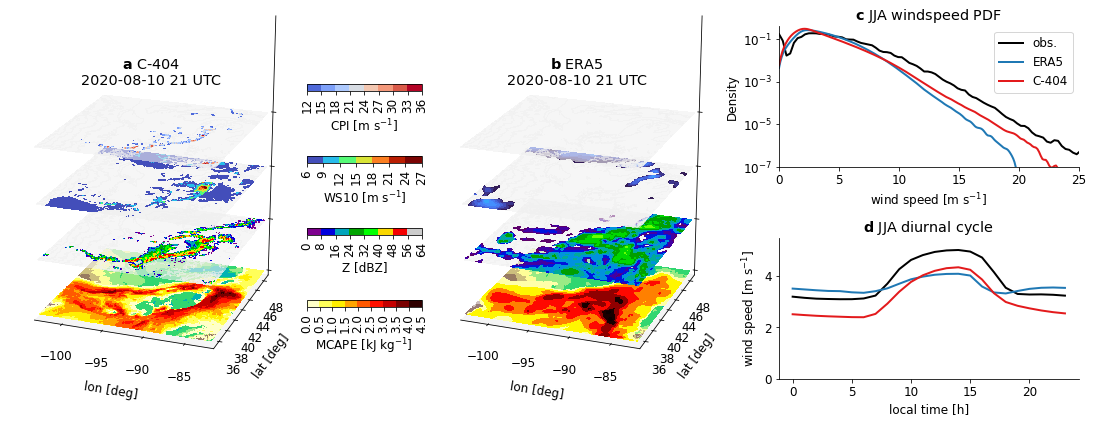

In [40]:
"""
.. versionadded:: 1.1.0
   This demo depends on new features added to contourf3d.
"""

from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

foc_area = [35,49,-103,-82]

fig = plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 12})

# =================================================
# =================================================
# =================================================
print('PLOT C-404')
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.05, right=0.3,
   bottom=-0.25, top=0.95,
   wspace=0.3, hspace=0.3)

# ax = fig.add_subplot(1, 3, 1, projection='3d')
ax = plt.subplot(gs1[0,0], projection='3d')


"""                                                                                                                                                    
Scale the axis relative to each other                                                                                                                        
"""
scale_x=1
scale_y=1
scale_z=2

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([scale_x, scale_y, scale_z, 1]))

HGT_M_cut = np.where((lon_wrf < foc_area[2]) | (lon_wrf > foc_area[3]), np.nan, HGT_M)
HGT_M_cut = np.where((lat_wrf > foc_area[1]) | (lat_wrf < foc_area[0]), np.nan, HGT_M_cut)
ax.contourf(lon_wrf,lat_wrf, HGT_M_cut,
                cmap = 'terrain', zdir='z', offset=0, vmin=-300,vmax=1700)

transp_layer = np.copy(HGT_M_cut)
# transp_layer[transp_layer > 0] = 1

# Plot CAPE, Z, ...
variables = ['MCAPE','Z','WS10','CPI']
units = ['kJ kg$^{-1}$','dBZ','m s$^{-1}$','m s$^{-1}$']
zlev = np.linspace(0,65,len(variables))
for va in range(len(variables)):
    if variables[va] == 'MCAPE':
        data_cut = np.copy(CAPE[:,:-1])
        data_cut[data_cut < 100] = np.nan
        data_cut = data_cut/1000
        cmap = 'hot_r'
        vmin_max = [0,4.500]
    if variables[va] == 'Z':
        data_cut = np.copy(REFL_10CM[:,:-1])
        data_cut[data_cut < 0] = np.nan
        cmap = 'nipy_spectral'
        vmin_max = [0,60]
    if variables[va] == 'WS10':
        data_cut = np.copy(UV10[:,:-1])
        data_cut[data_cut < 6] = np.nan
        cmap = 'turbo'
        vmin_max = [6,24]
    if variables[va] == 'CPI':
        data_cut = np.copy(coldpool_int[:,:-1])
        data_cut[data_cut < 12] = np.nan
        cmap = 'coolwarm'
        vmin_max = [12,34]
        
        
    
    data_cut = np.where((lon_wrf < foc_area[2]) | (lon_wrf > foc_area[3]), np.nan, data_cut)
    data_cut = np.where((lat_wrf > foc_area[1]) | (lat_wrf < foc_area[0]), np.nan, data_cut)
    
    if va > 0:
        ax.contourf(lon_wrf, lat_wrf, transp_layer,  
               colors=['#f0f0f0','#f0f0f0'], zdir='z', offset=zlev[va], alpha=0.6, extent='both')
    else:
        plt.title(r"$\bf{" + rgsLableABC[0] + "}$"+' C-404 \n'+str(time_case[tt_inmonth])[:13]+' UTC')
    
    cset = ax.contourf(lon_wrf, lat_wrf, data_cut,  
                       cmap = cmap, vmin = vmin_max[0], vmax = vmin_max[1], 
                       zdir='z', offset=zlev[va], alpha=1)
    
    # add color bars
    CbarAx = axes([0.31, 0.15+0.1*(va+1), 0.1, 0.01])
    cb = colorbar(cset, cax = CbarAx, orientation='horizontal')#, ticks=np.linspace(0,0.0015,41))
    # cb.ax.set_xticklabels(LEVS,rotation=90)
    cb.set_label(variables[va] + ' [' + units[va] + ']', fontsize=12)
    cb.ax.tick_params(labelsize=12, rotation=90) 

ax.set_xlabel('lon [deg]')
ax.set_xlim(foc_area[2], foc_area[3])
ax.set_ylabel('lat [deg]')
ax.set_ylim(foc_area[0], foc_area[1])
ax.set_zlabel('')
ax.set_zlim(0, 100)


ax.view_init(22, 290)
ax.grid(b=None)
ax.set_zticks(zlev)
ax.set_zticklabels([''] * len(variables))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))



# =================================================
# =================================================
# =================================================
print('plot ERA5')
gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.42, right=0.67,
   bottom=-0.25, top=0.95,
   wspace=0.05, hspace=0.3)

ax1 = plt.subplot(gs2[0,0], projection='3d')
# ax1 = fig.add_subplot(1, 3, 2, projection='3d')


"""                                                                                                                                                    
Scale the axis relative to each other                                                                                                                        
"""
scale_x=1
scale_y=1
scale_z=2

ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([scale_x, scale_y, scale_z, 1]))

HGT_M_cut = np.where((lon_wrf < foc_area[2]) | (lon_wrf > foc_area[3]), np.nan, HGT_M)
HGT_M_cut = np.where((lat_wrf > foc_area[1]) | (lat_wrf < foc_area[0]), np.nan, HGT_M_cut)
ax1.contourf(lon_wrf,lat_wrf, HGT_M_cut,
                cmap = 'terrain', zdir='z', offset=0, vmin=-300,vmax=1700)

transp_layer = np.copy(HGT_M_cut)

# Plot CAPE, Z, ...
variables = ['MCAPE','Z','WS10','CPI']
units = ['kJ kg$^{-1}$','dBZ','m s$^{-1}$','m s$^{-1}$']
zlev = np.linspace(0,65,len(variables))
for va in range(len(variables)):
    if variables[va] == 'MCAPE':
        data_cut = np.copy(CAPE_E[:,:])
        data_cut[data_cut < 100] = np.nan
        data_cut = data_cut/1000
        cmap = 'hot_r'
        vmin_max = [0,4.500]
    if variables[va] == 'Z':
        data_cut = np.copy(Z_E[:,:])
        data_cut[data_cut < 0] = np.nan
        cmap = 'nipy_spectral'
        vmin_max = [0,60]
    if variables[va] == 'WS10':
        data_cut = np.copy(UV10_E[:,:])
        data_cut[data_cut < 6] = np.nan
        cmap = 'turbo'
        vmin_max = [6,24]
    if variables[va] == 'CPI':
        data_cut = np.copy(CPI_E)
        data_cut[data_cut < 12] = 0
        cmap = 'coolwarm'
        vmin_max = [10,34]
    
    data_cut = np.where((Lon_F < foc_area[2]) | (Lon_F > foc_area[3]), np.nan, data_cut)
    data_cut = np.where((Lat_F > foc_area[1]) | (Lat_F < foc_area[0]), np.nan, data_cut)
    
    if va > 0:
        ax1.contourf(lon_wrf, lat_wrf, transp_layer,  
               colors=['#f0f0f0','#f0f0f0'], zdir='z', offset=zlev[va], alpha=0.6, extent='both')
    else:
        plt.title(r"$\bf{" + rgsLableABC[1] + "}$"+' ERA5 \n'+str(time_case[tt_inmonth])[:13]+' UTC')
    if np.nanmax(data_cut) != 0:
        ax1.contourf(Lon_F, Lat_F, data_cut,  
                           cmap = cmap, vmin = vmin_max[0], vmax = vmin_max[1], 
                           zdir='z', offset=zlev[va], alpha=1)

ax1.set_xlabel('lon [deg]')
ax1.set_xlim(foc_area[2], foc_area[3])
ax1.set_ylabel('lat [deg]')
ax1.set_ylim(foc_area[0], foc_area[1])
ax1.set_zlabel('')
ax1.set_zlim(0, 100)

ax1.view_init(22, 290)
ax1.grid(b=None)
ax1.set_zticks(zlev)
ax1.set_zticklabels([''] * len(variables))
ax1.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax1.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


# ===============================================
#         PLOT DIURNAL CYCLE AND PDF
# ===============================================
gs3 = gridspec.GridSpec(2,1)
gs3.update(left=0.72, right=0.98,
   bottom=0.15, top=0.64,
   wspace=0.15, hspace=0.5)

# ===============================================
# ['Gulf-Atlantic_coast.shp','Westcoast.shp','Front-Range.shp', 'Intermauntain-west.shp','Derecho_hotspot.shp']
re = REGIONS.index('Central_US.shp')
reg_sel = MaskStations == (re+1)
ax2 = plt.subplot(gs3[0,0])

data_st_sel = np.copy(data_stations[:,reg_sel,:])
FIN = ~np.isnan(data_st_sel[:,:,0])
sns.kdeplot(data_st_sel[:,:,0][FIN].flatten(), cut=0, c='k', bw=0.1, label = 'obs.', lw=2)
sns.kdeplot(data_st_sel[:,:,1][FIN].flatten(), cut=0, c='#1f78b4', bw=0.1, label = 'ERA5', lw=2)
sns.kdeplot(data_st_sel[:,:,2][FIN].flatten(), cut=0, c='#e31a1c', bw=0.1, label = 'C-404', lw=2)
ax2.set_xlabel('wind speed [m s$^{-1}$]')
ax2.set_yscale('log')
# ax2.set_xscale('log')
ax2.set_ylim([0.0000001,0.4])
ax2.set_xlim([0,25])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.title(r"$\bf{" + rgsLableABC[2] + "}$"+' JJA windspeed PDF')
plt.legend()


# ===============================================
# ['Gulf-Atlantic_coast.shp','Westcoast.shp','Front-Range.shp', 'Intermauntain-west.shp','Derecho_hotspot.shp']
re = REGIONS.index('Central_US.shp')
loc_time = -6
reg_sel = MaskStations == (re+1)
ax3 = plt.subplot(gs3[1,0])

jja_hours = np.isin(TimeHH.month, months)
jja_data = data_stations[jja_hours,:,:][:,reg_sel,:]
diurnal_cycle = np.reshape(jja_data, (int(jja_data.shape[0]/24),24, jja_data.shape[1], jja_data.shape[2]))
local_time = np.array(range(24))

plt.plot(local_time,np.roll(np.nanmean(diurnal_cycle[:,:,:,0], axis=(0,2)),loc_time), c='k', lw=2)
plt.plot(local_time,np.roll(np.nanmean(diurnal_cycle[:,:,:,1], axis=(0,2)),loc_time), c='#1f78b4', lw=2)
plt.plot(local_time,np.roll(np.nanmean(diurnal_cycle[:,:,:,2], axis=(0,2)),loc_time), c='#e31a1c', lw=2)
ax3.set_ylim([0,5.5])
ax3.set_xlabel('local time [h]')
ax3.set_ylabel('wind speed [m s$^{-1}$]')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
plt.title(r"$\bf{" + rgsLableABC[3] + "}$"+' JJA diurnal cycle')

sPlotFile=''
sPlotName= 'windgust-example_and_JJA-statistics.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

### Plot annual trends on map

In [41]:
wrf_uv10_trends.shape

(1015, 1366, 3, 5, 5)

        Plot map to: JJA_max_wind-speed-trends_spatially.jpg


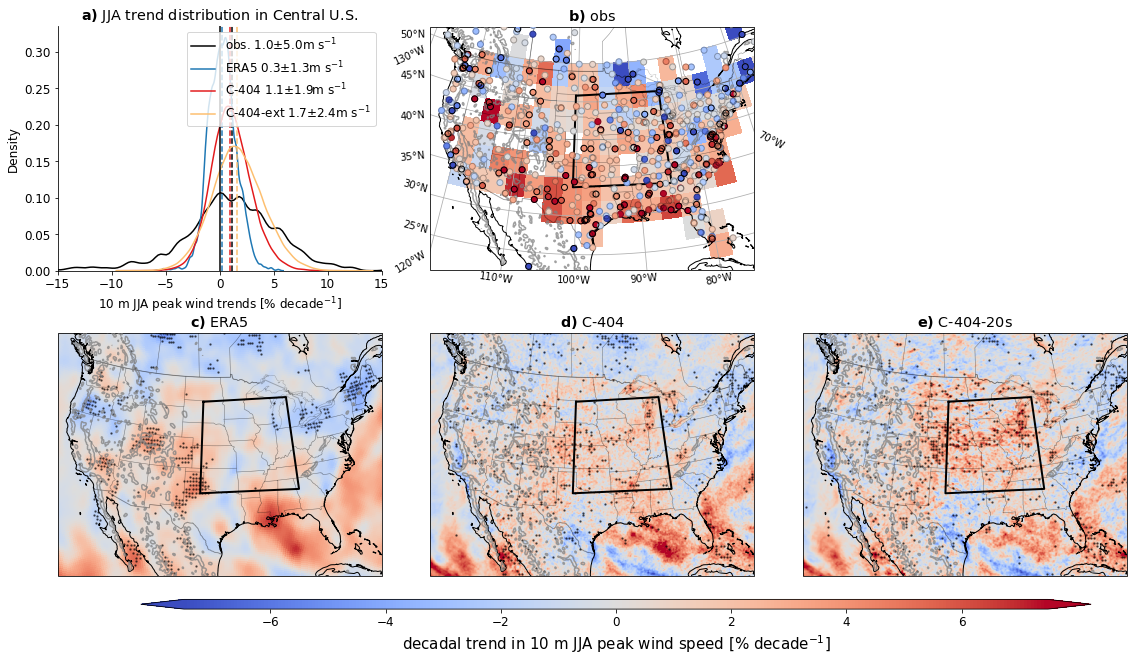

In [42]:
import cartopy.crs as ccrs
se=0
fig = plt.figure(figsize=(16.5,9))
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.15, hspace=0.25)
plt.rcParams.update({'font.size': 12})

prominence = scipy.ndimage.gaussian_filter(HGT_M,2.5)\
            - scipy.ndimage.gaussian_filter(HGT_M,10)

datasets = ['obs', 'ERA5', 'C-404', 'C-404-20s']
se = 3

# ################################################
### Plot PDF of trends in central US
ax = plt.subplot(gs1[0,0])
se = 3
st = 2
# sta_uv10_trends[st,da,me,se,:]
FIN = ~np.isnan(sta_uv10_trends[:,0,st,se,0])
obs_act = sta_uv10_trends[:,0,st,se,0][FIN].flatten()*1000
sns.kdeplot(obs_act, c='k', bw=0.1, label = 'obs. '+
            str(np.round(np.mean(obs_act), 1)) + '$\pm$' + str(np.round(np.std(obs_act), 1)) + 'm s$^{-1}$')
plt.axvline(x=np.median(obs_act), c='k', ls='--')
era_act = era_uv10_trends[MaskStations_era == 5,st,se,0].flatten()*1000
sns.kdeplot(era_act, c='#1f78b4', bw=0.1, label = 'ERA5 '+
            str(np.round(np.mean(era_act), 1)) + '$\pm$' + str(np.round(np.std(era_act), 1)) + 'm s$^{-1}$')
plt.axvline(x=np.median(era_act), c='#1f78b4', ls='--')
wrf_act = wrf_uv10_trends[MaskStations_wrf == 5,st,se,0].flatten()*1000
sns.kdeplot(wrf_act, c='#e31a1c', bw=0.1, label = 'C-404 '+
            str(np.round(np.mean(wrf_act), 1)) + '$\pm$' + str(np.round(np.std(wrf_act), 1)) + 'm s$^{-1}$')
plt.axvline(x=np.median(wrf_act), c='#e31a1c', ls='--')
wrf_act = wrf_uv10_extr_trends[MaskStations_wrf == 5,se,0].flatten()*1000
sns.kdeplot(wrf_act, c='#fdbf6f', bw=0.1, label = 'C-404-ext '+
            str(np.round(np.mean(wrf_act), 1)) + '$\pm$' + str(np.round(np.std(wrf_act), 1)) + 'm s$^{-1}$')
plt.axvline(x=np.median(wrf_act), c='#fdbf6f', ls='--')

ax.set_xlabel('10 m JJA peak wind trends [% decade$^{-1}$]')
plt.legend()
plt.xlim([-15, 15])
plt.axvline(x=0, c='k', ls='-')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r"$\bf{" + rgsLableABC[0] + ")}$"+' JJA trend distribution in Central U.S.')

# ################################################
### Plot trends in maps next

cmap = 'coolwarm'
stat_sel = [1,2]

XX = [1,0,1,2]
YY=[0,1,1,1]
for st in [1]: #range(2):
    if st == 0:
        col_range = 7.5
    elif st == 1:
        col_range = 7.5
    for da in range(4): #range(lin_trend_max.shape[2]):
        if da == 1:
            data_act = era_uv10_trends[:,:,stat_sel[st],se,:]
            lon_act = lon_era
            lat_act = lat_era
        elif da == 2:
            data_act = wrf_uv10_trends[:,:,stat_sel[st],se,:]
            lon_act = lon_wrf
            lat_act = lat_wrf
        elif da == 3:
            data_act = wrf_uv10_extr_trends[:,:,se,:]
            lon_act = lon_wrf
            lat_act = lat_wrf

        ax = plt.subplot(gs1[YY[da],XX[da]], projection=cart_proj)
        for re in [4]: #range(len(REGIONS)):
            plt.plot(Reg_Poly[REGIONS[re]][:,0], Reg_Poly[REGIONS[re]][:,1], c='k', 
                     lw=2, transform=ccrs.PlateCarree(), zorder = 3)

        clevs = np.arange(0,3600,200)
        #Load ColorMap
        from ExternalFunctions import gmtColormap
        rgrColMap=gmtColormap(GMTPath='/glade/u/home/prein/MyPython_Programs/python/ColorMaps/', fileName='DEM_screen')
        blue_red1 = LinearSegmentedColormap('BlueRed1', rgrColMap)

        plt.contour(Lon4, Lat4, prominence[:,:-1], 
                    transform=ccrs.PlateCarree(), 
                    levels=[200,9999], colors=['gray','gray'], alpha=0.75, zorder = 25)

        if (da != 0):
            mesh = plt.pcolormesh(lon_act,lat_act, scipy.ndimage.gaussian_filter(data_act[:,:,0]*1000, 2),  
                       cmap = cmap, vmin=-col_range, vmax=col_range, transform=ccrs.PlateCarree(), zorder = 2)
            hatch = plt.fill_between([-120,-60],20,55,hatch='///////',color="none",edgecolor='black') 
            
            if da == 1:
                scip = 2
            if da == 2:
                scip = 10
            significant = np.array(data_act[::scip,::scip,3], dtype=np.float32) <= 0.05
            plt.scatter(lon_act[::scip,::scip][significant],lat_act[::scip,::scip][significant], marker='o',
                        c='k', s=2, alpha=0.5, zorder = 20, transform=ccrs.PlateCarree())
            

        # plot station data on top of contour
        if da == 0:
            lon_bin = np.arange(-120,-60,3); lon_binc = (lon_bin[1:] + lon_bin[:-1])/2
            lat_bin = np.arange(20,55,3); lat_binc = (lat_bin[1:] + lat_bin[:-1])/2
            station_grid = np.zeros((len(lat_binc),len(lon_binc),5)); station_grid[:] = np.nan
            for la in range(len(lat_bin)-1):
                for lo in range(len(lon_bin)-1):
                    stations_in_grid = (lon_comp >= lon_bin[lo]) & \
                                       (lon_comp < lon_bin[lo+1]) & \
                                       (lat_comp >= lat_bin[la]) & \
                                       (lat_comp < lat_bin[la+1])
                    if np.sum(stations_in_grid) >= 2:
                        station_grid[la,lo] = np.mean(sta_uv10_trends[stations_in_grid,da,stat_sel[st],se,:], axis=0)
            plt.pcolormesh(lon_binc,lat_binc,station_grid[:,:,0]*10*100 ,
                          cmap = cmap, vmin=-col_range, vmax=col_range, transform=ccrs.PlateCarree(), zorder = 2,
                          alpha = 1)
            
            sc = plt.scatter(lon_comp,lat_comp, c=sta_uv10_trends[:,da,stat_sel[st],se,0]*10*100, vmin=-col_range, vmax=col_range, 
                        cmap=cmap, transform=ccrs.PlateCarree(), zorder = 30)
            sig = sta_uv10_trends[:,da,stat_sel[st],se,3] <= 0.05
            plt.scatter(lon_comp[sig],lat_comp[sig], facecolors='none', edgecolors='k', transform=ccrs.PlateCarree(), zorder = 30)
            plt.scatter(lon_comp[sig != 1],lat_comp[sig != 1], facecolors='none', edgecolors='k', transform=ccrs.PlateCarree(), zorder = 30, alpha=0.3)
        plt.title(r"$\bf{" + rgsLableABC[1+da] + ")}$"+ ' ' + datasets[da])


        ax.coastlines(zorder = 20)
        ax.add_feature(cf.BORDERS, alpha=0.25, zorder = 20)
        ax.add_feature(cf.STATES, lw=0.5, alpha=0.25, zorder = 20)
        ax.set_extent([-120, -75, 23, 53], crs=ccrs.PlateCarree())
        if da == 0:
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.right_labels = False
            gl.top_labels = False
            gl.xlabel_style = {'size': 10}
            gl.ylabel_style = {'size': 10}
#     if st == 0:
#         CbarAx = axes([0.1, 0.55, 0.8, 0.015])
#         cb = colorbar(sc, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
#         # cb.ax.set_xticklabels(LEVS,rotation=90)
#         cb.set_label('decadal trend in mean 10 m wind speed [% decade$^{-1}$]', fontsize=15)
#     else:
CbarAx = axes([0.15, 0.05, 0.8, 0.015])
cb = colorbar(sc, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('decadal trend in 10 m JJA peak wind speed [% decade$^{-1}$]', fontsize=15)


sPlotFile=''
sPlotName= 'JJA_max_wind-speed-trends_spatially.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)

In [43]:
trends_months.shape

(12, 5, 4, 7, 5)

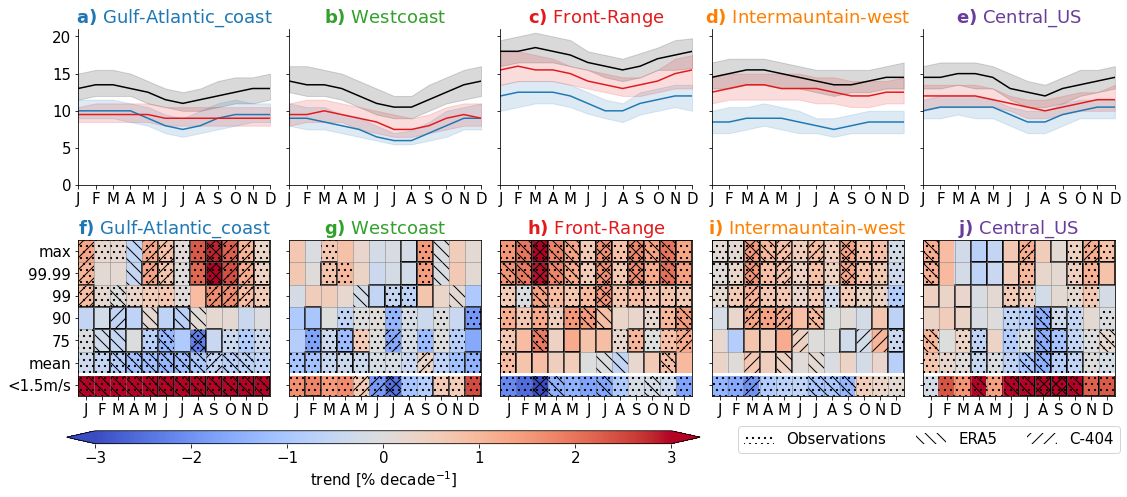

In [44]:
fig = plt.figure(figsize=(16,6))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(2,5)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.1, hspace=0.35)
plt.rcParams.update({'font.size': 15})
month_str = ['J','F','M','A','M','J','J','A','S','O','N','D']

# ========================================================
# ========================================================
# PLOT ANNUAL CYCLE OF WIND SPEED
reg_col = ['k','#1f78b4','#e31a1c']
for re in range(len(REGIONS)):
    ax = plt.subplot(gs1[0,re])
    reg_sel = MaskStations == (re+1)
    for da in range(len(reg_col)):
        plt.plot(range(12), np.nanmedian(annual_metrics[:,:,reg_sel,da,6], axis=(0,2)), c=reg_col[da])
        plt.fill_between(range(12), 
                         np.nanpercentile(annual_metrics[:,:,reg_sel,da,6], 25, axis=(0,2)), 
                         np.nanpercentile(annual_metrics[:,:,reg_sel,da,6], 75, axis=(0,2)), 
                         color=reg_col[da], alpha=0.15)
        
    ax.set_xticks(np.array(range(len(month_str))))
    ax.set_xticklabels(month_str)
    plt.ylim([0, 21])
    plt.xlim([0, 11])
    if re != 0:
        ax.set_yticklabels(['']*10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(r"$\bf{" + rgsLableABC[re] + ")}$"+' '+REGIONS[re][:-4], color = reg_colors[re])

# ========================================================
# ========================================================
# PLOT TRENDS IN HEATMAP

met_str = [str(metrics_ext[ii]) for ii in range(len(metrics_ext))]
met_str[0] = '<1.5m/s'


for re in range(len(REGIONS)):
    ax = plt.subplot(gs1[1,re])
    # REGIONS = ['Gulf-Atlantic_coast.shp','Westcoast.shp','Front-Range.shp', 'Intermauntain-west.shp','Derecho_hotspot.shp'],'Midwest.shp'
    da=1

    sc = plt.pcolormesh(np.median(trends_months[:,re,:3,:,0], axis=1).T * 1000, 
                   vmin = -3, vmax= 3,cmap='coolwarm')
    significance = (trends_months[:,re,:3,:,3] <= 0.1).T
    
    for me in range(significance.shape[0]):
        for mm in range(significance.shape[2]):
            if significance[me,0,mm] == 1:
                plt.fill_between([mm,mm+1,mm+1,mm],[me,me,me+1,me+1], facecolor="none", hatch="..", 
                                 edgecolor="k", linewidth=0.0)
            if significance[me,1,mm] == 1:
                plt.fill_between([mm,mm+1,mm+1,mm],[me,me,me+1,me+1], facecolor="none", hatch="\\\\", 
                                 edgecolor="k", linewidth=0.0)
            if significance[me,2,mm] == 1:
                plt.fill_between([mm,mm+1,mm+1,mm],[me,me,me+1,me+1], facecolor="none", hatch="//", 
                                 edgecolor="k", linewidth=0.0)
            # check if datasets agree in direction of change
            trend_agree = np.max([np.sum(trends_months[mm,re,:3,me,0] > 0), np.sum(trends_months[mm,re,:3,me,0] < 0)])
            if trend_agree == 3:
                plt.plot([mm,mm+1,mm+1,mm,mm],[me,me,me+1,me+1,me], color='k', lw=1.5)

    ax.set_yticks(np.array(range(significance.shape[0]))+0.5)
    if re == 0:
        ax.set_yticklabels(met_str[:])
    else:
        ax.set_yticklabels(['']*len(met_str))
    
    ax.set_xticks(np.array(range(len(month_str)))+0.5)
    ax.set_xticklabels(month_str)
    
    for xx in range(11):
        ax.axvline(xx+1, color='gray', linewidth=0.5)
    for yy in range(len(met_str)-1):
        ax.axhline(yy+1, color='gray', linewidth=0.5)
    ax.axhline(1, color='w', linewidth=3)
    
    plt.title(r"$\bf{" + rgsLableABC[re+len(REGIONS)] + ")}$"+' ' + REGIONS[re][:-4], color = reg_colors[re])

import matplotlib.patches as mpatches
circ1 = mpatches.Patch( facecolor='none',alpha=1,hatch='..',label='Observations')
circ2= mpatches.Patch( facecolor='none',alpha=1,hatch='\\\\',label='ERA5')
circ3 = mpatches.Patch(facecolor='none',alpha=1,hatch='//',label='C-404')
ax.legend(handles = [circ1,circ2,circ3],loc=2, bbox_to_anchor=(-1,-0.14), ncol=3)
    
CbarAx = axes([0.07, -0.01, 0.55, 0.03])
cb = colorbar(sc, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('trend [% decade$^{-1}$]', fontsize=15)

### Central U.S. trends

In [45]:
annual_metrics.shape

(40, 12, 523, 4, 7)

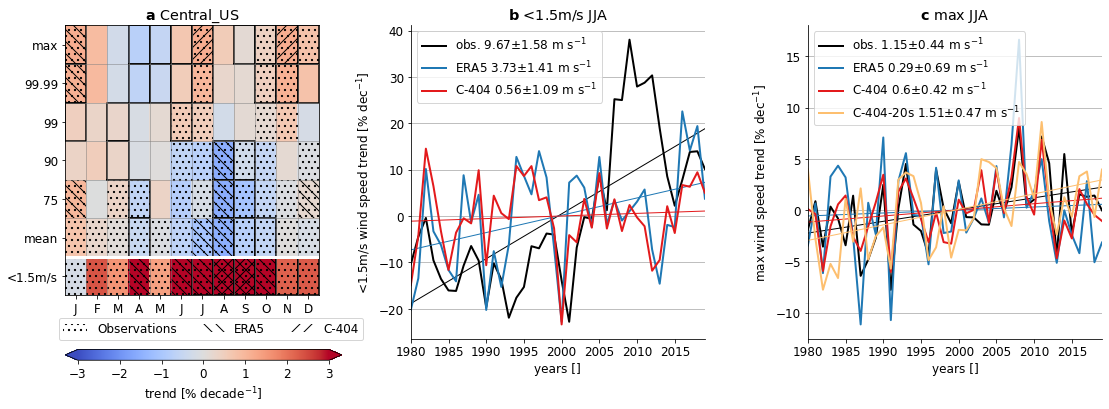

In [46]:
fig = plt.figure(figsize=(16,5))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.08, right=0.3,
   bottom=0.2, top=0.95,
   wspace=0.35, hspace=0.15)
plt.rcParams.update({'font.size': 12})


re = REGIONS.index('Central_US.shp')
reg_sel = MaskStations == (re+1)
datasets = ['obs.','ERA5','C-404','C-404-20s']
colors = ['k','#1f78b4','#e31a1c','#fdbf6f']



# ========================================================
# ========================================================
# PLOT TRENDS IN HEATMAP

met_str = [str(metrics_ext[ii]) for ii in range(len(metrics_ext))]
met_str[0] = '<1.5m/s'

re = REGIONS.index('Central_US.shp')
ax = plt.subplot(gs1[0,0])
# REGIONS = ['Gulf-Atlantic_coast.shp','Westcoast.shp','Front-Range.shp', 'Intermauntain-west.shp','Derecho_hotspot.shp'],'Midwest.shp'
da=1

sc = plt.pcolormesh(np.median(trends_months[:,re,:3,:,0], axis=1).T * 1000, 
               vmin = -3, vmax= 3,cmap='coolwarm')
significance = (trends_months[:,re,:3,:,3] <= 0.1).T

for me in range(significance.shape[0]):
    for mm in range(significance.shape[2]):
        if significance[me,0,mm] == 1:
            plt.fill_between([mm,mm+1,mm+1,mm],[me,me,me+1,me+1], facecolor="none", hatch="..", 
                             edgecolor="k", linewidth=0.0)
        if significance[me,1,mm] == 1:
            plt.fill_between([mm,mm+1,mm+1,mm],[me,me,me+1,me+1], facecolor="none", hatch="\\\\", 
                             edgecolor="k", linewidth=0.0)
        if significance[me,2,mm] == 1:
            plt.fill_between([mm,mm+1,mm+1,mm],[me,me,me+1,me+1], facecolor="none", hatch="//", 
                             edgecolor="k", linewidth=0.0)
        # check if datasets agree in direction of change
        trend_agree = np.max([np.sum(trends_months[mm,re,:3,me,0] > 0), np.sum(trends_months[mm,re,:3,me,0] < 0)])
        if trend_agree == 3:
            plt.plot([mm,mm+1,mm+1,mm,mm],[me,me,me+1,me+1,me], color='k', lw=1.5)

ax.set_yticks(np.array(range(significance.shape[0]))+0.5)
ax.set_yticklabels(met_str[:])

ax.set_xticks(np.array(range(len(month_str)))+0.5)
ax.set_xticklabels(month_str)

for xx in range(11):
    ax.axvline(xx+1, color='gray', linewidth=0.5)
for yy in range(len(met_str)-1):
    ax.axhline(yy+1, color='gray', linewidth=0.5)
ax.axhline(1, color='w', linewidth=3)

plt.title(r"$\bf{" + rgsLableABC[0] + " }$"+' ' + REGIONS[re][:-4])

import matplotlib.patches as mpatches
circ1 = mpatches.Patch( facecolor='none',alpha=1,hatch='..',label='Observations')
circ2= mpatches.Patch( facecolor='none',alpha=1,hatch='\\\\',label='ERA5')
circ3 = mpatches.Patch(facecolor='none',alpha=1,hatch='//',label='C-404')
ax.legend(handles = [circ1,circ2,circ3],loc=2, bbox_to_anchor=(-0.05,-0.06), ncol=3)
    
CbarAx = axes([0.08, 0.02, 0.24, 0.03])
cb = colorbar(sc, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('trend [% decade$^{-1}$]')#, fontsize=15)




### PLOT ANNUAL TIME SERIES
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.38, right=0.98,
   bottom=0.08, top=0.95,
   wspace=0.35, hspace=0.15)
stats = [0,6]
for st in range(len(stats)):
    ax = plt.subplot(gs1[0,st])
    if st == 0:
        data_nr = 3
    else:
        data_nr = 4
    for da in range(data_nr):
        data = np.nanmean(annual_metrics[:,5:8,reg_sel,da,stats[st]], axis=(1,2))
        data = ((data-np.mean(data))/np.mean(data))*100

        sns.regplot(years, data, color=colors[da], scatter_kws={'s':0}, ci = None, line_kws={'linewidth':1})
        regression = scipy.stats.linregress(years, data)
        plt.plot(years, data, c=colors[da], lw=2, label = datasets[da] + ' '+\
                str(np.round(regression[0]*10, 2)) + \
                '$\pm$' + str(np.round(regression[4]*10., 2)) + ' m s$^{-1}$', zorder=2)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('years []')
    ax.set_ylabel(met_str[stats[st]]+' wind speed trend [% dec$^{-1}$]')
    ax.grid(axis='y')
    
    plt.legend()
    plt.title(r"$\bf{" + rgsLableABC[1+st] + " }$"+' ' + met_str[stats[st]] + ' JJA')


In [47]:
trends_months[mm,re,0,:,3]*1000

array([5.41138529e-05, 1.29346332e-01, 1.49644352e+01, 2.09628928e+01,
       6.40815623e+02, 1.03265155e+02, 6.72297455e+01])

        Plot map to: JJA_station-analysis_v1.pdf


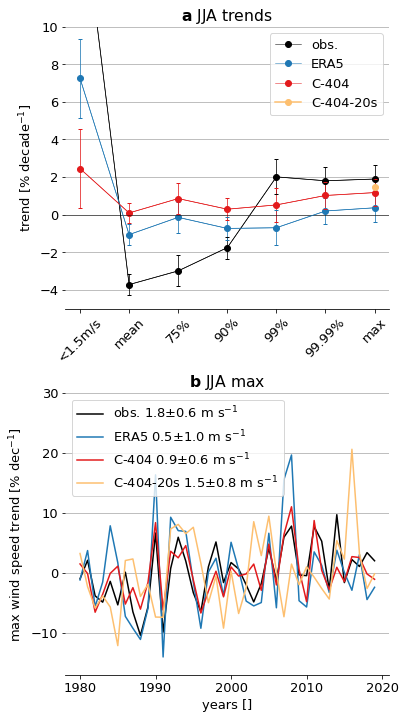

In [61]:
fig = plt.figure(figsize=(5,12))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(2,1)
gs1.update(left=0.08, right=0.98,
   bottom=0.2, top=0.95,
   wspace=0.35, hspace=0.3)
plt.rcParams.update({'font.size': 13})


re = REGIONS.index('Central_US.shp')
reg_sel = MaskStations == (re+1)
datasets = ['obs.','ERA5','C-404','C-404-20s']
colors = ['k','#1f78b4','#e31a1c','#fdbf6f']



# ========================================================
# ========================================================
# PLOT JJA trends dependent on percentile

met_str = [str(metrics_ext[ii]) for ii in range(len(metrics_ext))]
met_str[0] = '<1.5m/s'
for st in [2,3,4,5]:
    met_str[st] = met_str[st]+'%'

re = REGIONS.index('Central_US.shp')
ax = plt.subplot(gs1[0,0])
# REGIONS = ['Gulf-Atlantic_coast.shp','Westcoast.shp','Front-Range.shp', 'Intermauntain-west.shp','Derecho_hotspot.shp'],'Midwest.shp'
da=1

mm = 6
for da in range(len(datasets)-1):
    plt.plot(range(len(trends_months[mm,re,0,:,0])), trends_months[mm,re,da,:,0]*1000, 
             marker='o', color=colors[da], label = datasets[da], lw=0.5)
    plt.errorbar(range(len(trends_months[mm,re,0,:,0])), trends_months[mm,re,da,:,0]*1000, 
                yerr = trends_months[mm,re,0,:,4]*1000, color=colors[da], lw=0.75, capsize=2)
da = da+1
plt.plot(6, trends_months[mm,re,da,-1,0]*1000, 
         marker='o', color=colors[da], label = datasets[da])
plt.ylim([-5,10])

plt.axhline(y = 0, color = 'k', linestyle = '-', lw=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel('trend [% decade$^{-1}$]')
ax.yaxis.grid() # horizontal lines
plt.legend()
plt.title(r"$\bf{" + rgsLableABC[0] + " }$"+' JJA trends')

ax.set_xticks(np.array(range(significance.shape[0])))
ax.set_xticklabels(met_str[:], rotation=45)



### PLOT ANNUAL TIME SERIES

stats = [6] #[0,6]
for st in range(len(stats)):
    ax = plt.subplot(gs1[st+1,0])
    if stats[st] == 6:
        data_nr = 4
    else:
        data_nr = 3
    for da in range(data_nr):
        data = np.nanmean(annual_metrics[:,mm,reg_sel,da,stats[st]], axis=(1))
        data = ((data-np.mean(data))/np.mean(data))*100

#         sns.regplot(years, data, color=colors[da], scatter_kws={'s':0}, ci = None, line_kws={'linewidth':2})
        regression = scipy.stats.linregress(years, data)
        plt.plot(years, data, c=colors[da], lw=1.5, label = datasets[da] + ' '+\
                str(np.round(regression[0]*10, 1)) + \
                '$\pm$' + str(np.round(regression[4]*10., 1)) + ' m s$^{-1}$', zorder=2, alpha=1)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.grid() # horizontal lines
    ax.set_xlabel('years []')
    ax.set_ylabel(met_str[stats[st]]+' wind speed trend [% dec$^{-1}$]')
#     ax.grid(axis='y')
    
    plt.legend(loc='upper left')
    plt.title(r"$\bf{" + rgsLableABC[1+st] + " }$"+' JJA ' + met_str[stats[st]] )

    if stats[st] == 6:
        plt.ylim([-17,30])
#     plt.axhline(y = 0, color = 'k', linestyle = '-', lw=1)

    
sPlotFile=''
sPlotName= 'JJA_station-analysis_v1.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

In [49]:
stop()

--Call--
> /glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    250         sys.stdout.flush()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.
    254 



ipdb>  exit


BdbQuit: 

In [ ]:
from matplotlib import colors as c
wind_speed_colors = c.ListedColormap(['#6a8e20','#9acd33','#adff2f','#ffff00','#d3b68d','#ce8540',
                     '#fea400','#ff4500','#f9c2fe','#bb56d5','#9a30ce','#8370fe', '#fe0100', '#0082fe'])


In [ ]:
plt.pcolormesh(np.mean(wrf_uv10_mean[:,:,:,:,1], axis=(0,1)), cmap = 'coolwarm', vmin=0, vmax=5)

In [ ]:
plt.pcolormesh(np.mean(wrf_uv10_mean[:,:,:,:,2], axis=(0,1)), cmap = 'coolwarm', vmin=0, vmax=20)

In [ ]:
plt.pcolormesh(np.argmax(np.max(wrf_uv10_mean[:,:,:,:,2], axis=(0)), axis=0), cmap = 'coolwarm', vmin =0, vmax = 11)

### Read ERA5 data

In [ ]:
era5_windspeed = save_dir + str(years[0]) + '-' + str(years[-1]) + '_ERA5_stations_windspeed.npz'
if os.path.isfile(era5_windspeed) == False:
    era_var = ['u10','v10']
    REGION = [np.max(lat_wrf),np.max(lon_wrf),np.min(lat_wrf),np.min(lon_wrf)]
    era_u10 = ReadERA5(TimeHH,      # Time period to read (this program will read hourly data)
                        era_var[0],        # Variable name. See list below for defined variables
                        -1,         # Pressure level of variable
                        REGION)    # Region to read. Format must be <[N,E,S,W]> in degrees from -180 to +180 longitude
    era_v10 = ReadERA5(TimeHH,      # Time period to read (this program will read hourly data)
                        era_var[1],        # Variable name. See list below for defined variables
                        -1,         # Pressure level of variable
                        REGION)    # Region to read. Format must be <[N,E,S,W]> in degrees from -180 to +180 longitude
    era_uv10 = (era_u10[0]**2 + era_v10[0]**2)**0.5
    
    np.savez(era5_windspeed,
            TimeHH,TimeHH,
            LatST = LatST,
            LonST = LonST,
            HeigtST = HeigtST,
            era_uv10 = era_uv10,
            lon_era = era_v10[2],
            lat_era = era_v10[1])
else:
    data = np.load(era5_windspeed)
    era_uv10 = data['era_uv10']
    lon_era = data['lon_era']
    lat_era = data['lat_era']

In [ ]:
# get stations data from ERA5
# get the location of the stations
# nearest gridcell to station
lon_era = np.array(lon_era, dtype=np.float16)
lat_era = np.array(lat_era, dtype=np.float16)
StationsInModel = np.zeros((len(LonST),2)); StationsInModel[:] = np.nan
for st in range(len(LonST)):
    try:
        abslat = np.abs(lat_era-LatST[st])
        abslon= np.abs(lon_era-LonST[st])
        Loc = np.argmin(np.maximum(abslon,abslat))
        StationsInModel[st,:] = np.unravel_index(Loc, (lon_era.shape[0],lon_era.shape[1]))
    except:
        continue
StationsInModel = StationsInModel.astype('int')
era_uv10_st = era_uv10[:,StationsInModel[:,0],StationsInModel[:,1]]

In [ ]:
### Calculate trends in ERA5 wind speed

era_windtrends = save_dir + str(years[0]) + '-' + str(years[-1]) + '_ERA_grid-trends.npz'
if os.path.isfile(conus404_windtrends) == False:
    # calculate monthly statistics
    metrics = ['<1','mean','max']
    era_uv10_mean = np.zeros((len(years), 12,lon_era.shape[0],lon_era.shape[1], len(metrics)), dtype=np.float16); era_uv10_mean[:] = np.nan

    for yy in tqdm(range(len(years))):
        for mm in range(12):
            time_sel = np.isin(TimeHH.month, [mm+1]) & (TimeHH.year == years[yy])
            data_mm = era_uv10[time_sel,:,:]
            for me in range(len(metrics)):
                if metrics[me] == '<1':
                    era_uv10_mean[yy,mm,:,:,me] = np.nansum(data_mm[:,:,:] < 1, axis=0)/np.nansum(time_sel)
                elif metrics[me] == 'mean':
                    era_uv10_mean[yy,mm,:,:,me] = np.nanmean(data_mm[:,:,:], axis=0)
                elif metrics[me] == 'max':
                    era_uv10_mean[yy,mm,:,:,me] = np.nanmax(data_mm[:,:,:], axis=0)
                else:
                    continue

    era5_windtrends = save_dir + str(years[0]) + '-' + str(years[-1]) + '_ERA5_grid-trends.npz'
    if os.path.isfile(era5_windtrends) == False:
        era_uv10_trends = np.zeros((lon_era.shape[0],lon_era.shape[1], len(metrics),5), dtype=np.float16); era_uv10_trends[:] = np.nan
        for la in tqdm(range(lon_era.shape[0])):
            for lo in range(lon_era.shape[1]):
                for me in range(len(metrics)):
                    if metrics[me] == 'max':
                        data_act = np.max(era_uv10_mean[:,:,la,lo,me], axis=1)
                    else:
                        data_act = np.mean(era_uv10_mean[:,:,la,lo,me], axis=1)
                    era_uv10_trends[la,lo,me,:] = scipy.stats.linregress(years, data_act)
                    era_uv10_trends[la,lo,me,0] = era_uv10_trends[la,lo,me,0]/np.mean(data_act)
        np.savez(era_windtrends,
                era_uv10_mean = era_uv10_mean,
                era_uv10_trends = era_uv10_trends,
                lat_era = lat_era,
                lon_era = lon_era,
                metrics = metrics,
                years =years)
else:
    data =np.load(era_windtrends)
    era_uv10_trends = data['era_uv10_trends']

In [ ]:
era5_windtrends = save_dir + str(years[0]) + '-' + str(years[-1]) + '_ERA5_grid-trends.npz'
if os.path.isfile(era5_windtrends) == False:
    era_uv10_trends = np.zeros((lon_era.shape[0],lon_era.shape[1], len(metrics),5), dtype=np.float16); era_uv10_trends[:] = np.nan
    for la in tqdm(range(lon_era.shape[0])):
        for lo in range(lon_era.shape[1]):
            for me in range(len(metrics)):
                if metrics[me] == 'max':
                    data_act = np.max(era_uv10_mean[:,:,la,lo,me], axis=1)
                else:
                    data_act = np.mean(era_uv10_mean[:,:,la,lo,me], axis=1)
                era_uv10_trends[la,lo,me,:] = scipy.stats.linregress(years, data_act)
                era_uv10_trends[la,lo,me,0] = era_uv10_trends[la,lo,me,0]/np.mean(data_act)
    np.savez(era5_windtrends,
            era_uv10_trends = era_uv10_trends,
            LatST = LatST,
            LonST = LonST,
            metrics = metrics)
else:
    data =np.load(era5_windtrends)
    era_uv10_trends = data['era_uv10_trends']
    metrics = data['metrics']

In [ ]:
# remove records that have less than 80 % of the data for more than 20 % of the years
compete_station_frac_yy = np.sum(obs_frac_season >= 0.8, axis= 0)/obs_frac_season.shape[0]

st_complete = np.copy(ST_DATA_windspeed[:,compete_station_frac_yy[0,:] >= 0.8 ])
wrf_complete = np.copy(wrf_uv10[:,compete_station_frac_yy[0,:] >= 0.8 ])
era_complete = np.copy(era_uv10_st[:,compete_station_frac_yy[0,:] >= 0.8 ])

lon_comp = np.copy(LonST[compete_station_frac_yy[0,:] >= 0.8])
lat_comp = np.copy(LatST[compete_station_frac_yy[0,:] >= 0.8])

NaN = np.isnan(st_complete)
wrf_complete[NaN] = np.nan
era_complete[NaN] = np.nan

### get stations in subregions

In [ ]:
import geopandas as gpd
REGIONS = ['Gulf-Atlantic_coast.shp','Westcoast.shp','Front-Range.shp', 'Intermauntain-west.shp','Derecho_hotspot.shp'] #'Midwest.shp',
reg_colors = ['#1f78b4','#33a02c','#e31a1c','#ff7f00','#6a3d9a','#b2df8a']
Reg_Poly = {}
MaskStations = np.zeros((lat_comp.shape[0]))
rgrGridCells=[(lon_comp.flatten()[ii],lat_comp.flatten()[ii]) for ii in range(len(lat_comp.flatten()))]
for re in tqdm(range(len(REGIONS))):
    data = gpd.read_file('/glade/u/home/prein/papers/2022_Wind-Changes/shapefiles/'+REGIONS[re])
    Coordinates = data['geometry']
    sf = 0
    TEST = np.array(Coordinates[sf].exterior.coords.xy)
    ctr=TEST.T
    Reg_Poly[REGIONS[re]] = ctr
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    TMP = np.reshape(TMP, (lat_comp.shape[0]))
    MaskStations[TMP==1] = re+1
#     MaskStations = np.append(MaskStations,[re+1]*len(iStationSelect))
MaskStations = MaskStations.astype('int')
    
MaskStations[MaskStations < 0] = 0

Region_indices = ndimage.find_objects(MaskStations)
# Region_indices = ndimage.find_objects(MaskStations)

### Bin the wind speed data to the observational accuracy

In [ ]:
# unique_wind = np.unique(ST_DATA_windspeed[:,:])
# unique_wind = unique_wind[~np.isnan(unique_wind)]
wrf_complete = np.round(wrf_complete,1)
era_complete = np.round(era_complete,1)

In [ ]:
# st = 401
# # sns.kdeplot(ST_DATA_windspeed[ST_DATA_windspeed[:,st]>0,st].flatten(), cut=0, c='k', bw=0.1)
# FIN = ~np.isnan(st_complete[:,st])
# sns.kdeplot(st_complete[FIN,st].flatten(), cut=0, c='k', bw=0.1)
# sns.kdeplot(np.array(era_complete[FIN,st].flatten(), dtype=np.float32), cut=0, c='b', bw=0.1)
# sns.kdeplot(np.array(wrf_complete[FIN,st].flatten(), dtype=np.float32), cut=0, c='r', bw=0.1)

In [ ]:
# foc_region = [45, -90, 35, -100]
# time_sel = np.isin(TimeHH.month, [6,7,8]) & (TimeHH.year >= 1980)
# st_in_regions = (lon_comp >= foc_region[3]) & (lon_comp <= foc_region[1]) & \
#                 (lat_comp >= foc_region[2]) & (lat_comp <= foc_region[0])

# FIN = ~np.isnan(st_complete[time_sel,:][:,st_in_regions]) & (st_complete[time_sel,:][:,st_in_regions] > 0.5)
# sns.kdeplot(st_complete[time_sel,:][:,st_in_regions][FIN].flatten(), cut=0, c='k', bw=0.1)
# sns.kdeplot(np.array(era_complete[time_sel,:][:,st_in_regions][FIN].flatten(), dtype=np.float32), cut=0, c='b', bw=0.1)
# sns.kdeplot(np.array(wrf_complete[time_sel,:][:,st_in_regions][FIN].flatten(), dtype=np.float32), cut=0, c='r', bw=0.1)

In [ ]:
data_stations = np.array(
                np.append(
                np.append(st_complete[:,:,None],era_complete[:,:,None], axis=2), 
                          wrf_complete[:,:,None], axis=2),
                dtype=np.float32)

In [ ]:
annual_max_stations = np.zeros((len(years), 5, data_stations.shape[1], data_stations.shape[2]))
for yy in tqdm(range(len(years))):
    for se in range(5):
        if se == 0:
            months = [1,2,3,4,5,6,7,8,9,10,11,12]
        elif se == 1:
            months = [1,2,12]
        if se == 2:
            months = [3,4,5]
        if se == 3:
            months = [6,7,8]
        if se == 4:
            months = [9,10,11]
        time_sel = (TimeHH.year == years[yy]) & np.isin(TimeHH.month, months)
        annual_max_stations[yy, se,:,:] = np.nanmax(data_stations[time_sel,:,:], axis=0)

### Calculate annual time series of metrics

In [ ]:
moveav = 30 # day window
annual_metrics = np.zeros((len(years), 12, data_stations.shape[1], data_stations.shape[2], len(metrics)))
for yy in tqdm(range(len(years))):
    for mm in range(12):
        mm0 = mm
        mm1 = mm + 1
        mm2 = mm + 2
        if mm0 == 0:
            mm0 = 12
        if mm2 == 13:
            mm2 = 1
        time_sel = (TimeHH.year == years[yy]) & np.isin(TimeHH.month, [mm0,mm1,mm2])
        data_year = data_stations[time_sel,:,:]
        for me in range(len(metrics)):
            if metrics[me] == '<1':
                annual_metrics[yy, mm,:,:,me] = np.nansum(data_year[:,:,:] < 1, axis=0)/np.nansum(~np.isnan(data_year[:,:,:]), axis=0)
            elif metrics[me] == 'mean':
                annual_metrics[yy, mm,:,:,me] = np.nanmean(data_year[:,:,:], axis=0)
            elif metrics[me] == 'max':
                annual_metrics[yy, mm,:,:,me] = np.nanmax(data_year[:,:,:], axis=0)
            else:
                annual_metrics[yy, mm,:,:,me] = np.nanpercentile(data_year[:,:,:], metrics[me],axis=0)

In [ ]:
### calculate trends in the monthly statistics
trends_months = np.zeros((12, len(REGIONS), data_stations.shape[2], len(metrics), 5))
FIN = (years != 1997)
for mm in tqdm(range(12)):
    for me in range(len(metrics)):
        data_act = annual_metrics[FIN,mm,:,:,me]
        for re in range(len(REGIONS)):
            reg_sel = MaskStations == (re+1)
            data_reg = np.nanmedian(data_act[:,reg_sel,:], axis=1)
            for da in range(3):
                trends_months[mm, re, da,me,:] = scipy.stats.linregress(years[FIN], data_reg[:,da])
                trends_months[mm, re, da,me,0] = (trends_months[mm, re, da, me, 0])/np.mean(data_reg[:,da])


In [ ]:
metrics

In [ ]:
fig = plt.figure(figsize=(16,6))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(2,5)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.1, hspace=0.35)
plt.rcParams.update({'font.size': 15})
month_str = ['J','F','M','A','M','J','J','A','S','O','N','D']

# ========================================================
# ========================================================
# PLOT DIURNAL CYCLE OF WIND SPEED
reg_col = ['k','#1f78b4','#e31a1c']
for re in range(len(REGIONS)):
    ax = plt.subplot(gs1[0,re])
    reg_sel = MaskStations == (re+1)
    for da in range(len(reg_col)):
        plt.plot(range(12), np.nanmedian(annual_metrics[:,:,reg_sel,da,6], axis=(0,2)), c=reg_col[da])
        plt.fill_between(range(12), 
                         np.nanpercentile(annual_metrics[:,:,reg_sel,da,6], 25, axis=(0,2)), 
                         np.nanpercentile(annual_metrics[:,:,reg_sel,da,6], 75, axis=(0,2)), 
                         color=reg_col[da], alpha=0.15)
        
    ax.set_xticks(np.array(range(len(month_str)))+0.5)
    ax.set_xticklabels(month_str)
    plt.ylim([0, 21])
    plt.xlim([0, 11])
    if re != 0:
        ax.set_yticklabels(['']*10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(r"$\bf{" + rgsLableABC[re] + ")}$"+' '+REGIONS[re][:-4], color = reg_colors[re])

# ========================================================
# ========================================================
# PLOT TRENDS IN HEATMAP

met_str = [str(metrics[ii]) for ii in range(len(metrics))]
met_str[0] = '<1m/s'


for re in range(len(REGIONS)):
    ax = plt.subplot(gs1[1,re])
    # REGIONS = ['Gulf-Atlantic_coast.shp','Westcoast.shp','Front-Range.shp', 'Intermauntain-west.shp','Derecho_hotspot.shp'],'Midwest.shp'
    da=1

    sc = plt.pcolormesh(np.mean(trends_months[:,re,:,:,0], axis=1).T * 1000, 
                   vmin = -3, vmax= 3,cmap='coolwarm')
    significance = (trends_months[:,re,:,:,3] <= 0.1).T
    
    for me in range(significance.shape[0]):
        for mm in range(significance.shape[2]):
            if significance[me,0,mm] == 1:
                plt.fill_between([mm,mm+1,mm+1,mm],[me,me,me+1,me+1], facecolor="none", hatch="..", 
                                 edgecolor="k", linewidth=0.0)
            if significance[me,1,mm] == 1:
                plt.fill_between([mm,mm+1,mm+1,mm],[me,me,me+1,me+1], facecolor="none", hatch="\\\\", 
                                 edgecolor="k", linewidth=0.0)
            if significance[me,2,mm] == 1:
                plt.fill_between([mm,mm+1,mm+1,mm],[me,me,me+1,me+1], facecolor="none", hatch="//", 
                                 edgecolor="k", linewidth=0.0)

    ax.set_yticks(np.array(range(significance.shape[0]))+0.5)
    if re == 0:
        ax.set_yticklabels(met_str[:])
    else:
        ax.set_yticklabels(['']*len(met_str))
    
    ax.set_xticks(np.array(range(len(month_str)))+0.5)
    ax.set_xticklabels(month_str)
    
    for xx in range(11):
        ax.axvline(xx+1, color='gray', linewidth=0.5)
    for yy in range(len(met_str)-1):
        ax.axhline(yy+1, color='gray', linewidth=0.5)
    ax.axhline(1, color='k', linewidth=3)
    
    plt.title(r"$\bf{" + rgsLableABC[re+len(REGIONS)] + ")}$"+' ' + REGIONS[re][:-4], color = reg_colors[re])

import matplotlib.patches as mpatches
circ1 = mpatches.Patch( facecolor='none',alpha=1,hatch='..',label='Observations')
circ2= mpatches.Patch( facecolor='none',alpha=1,hatch='\\\\',label='ERA5')
circ3 = mpatches.Patch(facecolor='none',alpha=1,hatch='//',label='C-404')
ax.legend(handles = [circ1,circ2,circ3],loc=2, bbox_to_anchor=(-1,-0.14), ncol=3)
    
CbarAx = axes([0.07, -0.01, 0.55, 0.03])
cb = colorbar(sc, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('trend [% decade$^{-1}$]', fontsize=15)

In [ ]:
import cartopy.crs as ccrs
se=0
fig = plt.figure(figsize=(16,5))
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.05, hspace=0.35)
plt.rcParams.update({'font.size': 15})

prominence = scipy.ndimage.gaussian_filter(HGT_M,2.5)\
            - scipy.ndimage.gaussian_filter(HGT_M,10)

datasets = ['obs', 'ERA5', 'C-404']
for da in range(lin_trend_max.shape[2]):
    ax = plt.subplot(gs1[0,da], projection=cart_proj)
    
    # plot regions
#     if da == 0:
    for re in range(len(REGIONS)):
        plt.plot(Reg_Poly[REGIONS[re]][:,0], Reg_Poly[REGIONS[re]][:,1], c=reg_colors[re], 
                 lw=3, transform=ccrs.PlateCarree(), zorder = 1)
    
    cs = plt.contourf(Lon4, Lat4,LSM4[:],levels=[0,0.0001], colors = 'skyblue', 
                      transform=ccrs.PlateCarree(), alpha=0.25)

    clevs = np.arange(0,3600,200)
    #Load ColorMap
    from ExternalFunctions import gmtColormap
    rgrColMap=gmtColormap(GMTPath='/glade/u/home/prein/MyPython_Programs/python/ColorMaps/', fileName='DEM_screen')
    blue_red1 = LinearSegmentedColormap('BlueRed1', rgrColMap)
        
    plt.contourf(Lon4, Lat4, prominence, 
                transform=ccrs.PlateCarree(), 
                levels=[0,200,9999], colors=['white','gray','gray'], alpha=0.75, zorder = 0)
    
    sc = plt.scatter(lon_comp,lat_comp, c=lin_trend_max[se,:,da,0]*10*100, vmin=-5,vmax=5, 
                cmap='coolwarm', transform=ccrs.PlateCarree(), zorder = 10)
    sig = lin_trend_max[se,:,da,3] <= 0.1
    plt.scatter(lon_comp[sig],lat_comp[sig], facecolors='none', edgecolors='k', transform=ccrs.PlateCarree(), zorder = 11)
    plt.title(datasets[da])
    

    ax.coastlines()
    ax.add_feature(cf.BORDERS, alpha=0.25)
    ax.add_feature(cf.STATES, lw=0.5, alpha=0.25)
    ax.set_extent([-120, -75, 23, 53], crs=ccrs.PlateCarree())
#     gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#     gl.left_labels = False

CbarAx = axes([0.1, 0.05, 0.8, 0.03])
cb = colorbar(sc, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('decadal trend in annual max. 10 m wind speed [% decade$^{-1}$]', fontsize=15)


### Read hourly WRF data for calculating trends and average statistics

In [ ]:
save_wrf_stats = ''

In [ ]:
scipy.stats.linregress(years[excl], np.nanmean(annual_max_stations[:,se,st_in_regions,2],axis=1)[excl])

In [ ]:
plt.plot(years[excl], np.nanmean(annual_metrics[:,6,st_in_regions,0,6],axis=1)[excl])

In [ ]:
(scipy.stats.linregress(years[excl], np.nanmean(annual_metrics[:,6,st_in_regions,0,6],axis=1)[excl])[0]/np.nanmean(annual_metrics[:,6,st_in_regions,0,6]))*1000

In [ ]:
fig = plt.figure(figsize=(16,3))
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.05, hspace=0.35)

ax = plt.subplot(gs1[0,0])
plt.scatter(lon_comp,lat_comp, c=np.nanmean(st_complete, axis=0), cmap='coolwarm', vmin=0, vmax=8)
plt.title('obs')

ax = plt.subplot(gs1[0,1])
plt.scatter(lon_comp,lat_comp, c=np.nanmean(np.array(era_complete, np.float32), axis=0), cmap='coolwarm', vmin=0, vmax=8)
plt.title('era5')

ax = plt.subplot(gs1[0,2])
plt.scatter(lon_comp,lat_comp, c=np.nanmean(np.array(wrf_complete, np.float32), axis=0), cmap='coolwarm', vmin=0, vmax=8)
plt.title('wrf')

In [ ]:
fig = plt.figure(figsize=(16,3))
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.05, hspace=0.35)

ax = plt.subplot(gs1[0,0])
plt.scatter(lon_comp,lat_comp, c=np.nanpercentile(st_complete, 99.99, axis=0), cmap='coolwarm', vmin=0, vmax=30)
plt.title('obs')

ax = plt.subplot(gs1[0,1])
plt.scatter(lon_comp,lat_comp, c=np.nanpercentile(era_complete, 99.99, axis=0), cmap='coolwarm', vmin=0, vmax=30)
plt.title('era5')

ax = plt.subplot(gs1[0,2])
plt.scatter(lon_comp,lat_comp, c=np.nanpercentile(wrf_complete, 99.99, axis=0), cmap='coolwarm', vmin=0, vmax=30)
plt.title('wrf')

In [ ]:
time_sel = np.isin(TimeHH.month, [9,10,11])

In [ ]:
correlations = np.zeros((st_complete.shape[1],2)); correlations[:] = np.nan
for st in range(st_complete.shape[1]):
    FIN = ~np.isnan(st_complete[time_sel,st])
    try:
        correlations[st,:] = scipy.stats.pearsonr(st_complete[time_sel,st][FIN],wrf_complete[time_sel,st][FIN])
    except:
        continue
        
plt.scatter(lon_comp,lat_comp, c=correlations[:,0], cmap='coolwarm', vmin=0, vmax=1)

In [ ]:
correlations_era = np.zeros((st_complete.shape[1],2)); correlations_era[:] = np.nan
for st in range(st_complete.shape[1]):
    FIN = ~np.isnan(st_complete[time_sel,st])
    try:
        correlations_era[st,:] = scipy.stats.pearsonr(st_complete[time_sel,st][FIN], era_complete[time_sel,st][FIN])
    except:
        continue
plt.scatter(lon_comp,lat_comp, c=correlations_era[:,0], cmap='coolwarm', vmin=0, vmax=1)

In [ ]:
plt.scatter(lon_comp,lat_comp, c=correlations[:,0]-correlations_era[:,0], cmap='coolwarm', vmin=-0.2, vmax=0.2)

### Plot the data

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

In [ ]:
# # ========= plot 4 km
# #plot blue ocean and lakes
# clevs=0

# ncfile = Dataset('/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc')
# HGT_M = getvar(ncfile, "HGT_M")
# cart_proj = get_cartopy(HGT_M)
# ncid.close()

# for tt in tqdm(range(len(TimeHH))):

#     fig = plt.figure(figsize=(25,9.5))
#     plt.rcParams.update({'font.size': 18})
#     gs1 = gridspec.GridSpec(1,2)
#     gs1.update(left=0.05, right=0.99,
#                bottom=0.21, top=0.93,
#                wspace=0.05, hspace=0.15)


#     datasets = ['ERA5','CONUS404']
#     for da in range(len(datasets)):
#         ax = plt.subplot(gs1[0,da], projection=cart_proj)
#         pos1 = ax.get_position()
#         if datasets[da] == 'ERA5':
#             data = np.copy(era_uv10[tt,:])
#             lat = lat_era
#             lon = lon_era
#         if datasets[da] == 'CONUS404':
#             data = np.copy(wrf_uv10[tt,:])
#             lat = lat_wrf
#             lon = lon_wrf


#         cs = plt.pcolormesh(lon, lat, data,
#                               vmin=0,
#                               vmax = 10, 
#                               cmap = 'Spectral_r', transform=ccrs.PlateCarree())

#         ax.coastlines()
#         ax.add_feature(cf.BORDERS)
#         ax.add_feature(cf.STATES, lw=0.5)
#         ax.set_extent((-123, -73, 22, 55), ccrs.PlateCarree())

#         gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#         gl.right_labels = False

#         plt.title(datasets[da]+' '+str(TimeHH[tt])[:13]+': 10 m wind speed')


#     # Add a color bar
#     cb = plt.colorbar(cs, ax=ax, shrink=.98)
#     cb.set_label('10 m wind speed [m/s]', fontsize=18)


#     sPlotFile=PlotDir
#     sPlotName= str(tt).zfill(3)+'_CONUS404-vs-ERA5_uv10_'+str(TimeHH[0])[:10] + '-' +str(TimeHH[-1])[:10]+'.jpg'
#     if os.path.isdir(sPlotFile) != 1:
#         subprocess.call(["mkdir","-p",sPlotFile])
# #     print( '        Plot map to: '+sPlotFile+sPlotName)
#     fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)


### Plot PDF of wind speed in central US

In [ ]:
foc_region = [40, -95, 35, -100]

era_region = (lat_era >= foc_region[2]) & (lat_era <= foc_region[0]) & \
             (lon_era >= foc_region[3]) & (lon_era <= foc_region[1])
era_region = era_uv10[:,era_region]
era_pdf = era_region.flatten()


wrf_region = (lat_wrf >= foc_region[2]) & (lat_wrf <= foc_region[0]) & \
             (lon_wrf >= foc_region[3]) & (lon_wrf <= foc_region[1])
wrf_region = wrf_uv10[:,wrf_region]
wrf_pdf = wrf_region.flatten()

In [ ]:
yy_w,xx_w = plt.psd(wrf_region[:,1000], 512, 1/24, c='r')
plt.close()
yy_e,xx_e = plt.psd(era_region[:,100], 512, 1/24, c='k')
plt.close()

### Spetral kinetic energey spectra (code from Julia)

In [ ]:
import numpy as np 
import xarray as xr
from pathlib import Path
from scipy import fft # package needed for DCT transformation


# plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
foc_region = [49, -85, 30, -105]
wrf_region = (lat_wrf >= foc_region[2]) & (lat_wrf <= foc_region[0]) & \
             (lon_wrf >= foc_region[3]) & (lon_wrf <= foc_region[1])
wrf_iregion = [np.where(np.max(wrf_region, axis=1) == True)[0][0],
                np.where(np.max(wrf_region, axis=1) == True)[0][-1],
                np.where(np.max(wrf_region, axis=0) == True)[0][0],
                np.where(np.max(wrf_region, axis=0) == True)[0][-1]]

era_region = (lat_era >= foc_region[2]) & (lat_era <= foc_region[0]) & \
             (lon_era >= foc_region[3]) & (lon_era <= foc_region[1])
era_iregion = [np.where(np.max(era_region, axis=1) == True)[0][0],
                np.where(np.max(era_region, axis=1) == True)[0][-1],
                np.where(np.max(era_region, axis=0) == True)[0][0],
                np.where(np.max(era_region, axis=0) == True)[0][-1]]

In [ ]:
### Work on WRF
wrf_region_u = wrf_data[:,wrf_iregion[0]:wrf_iregion[1],wrf_iregion[2]:wrf_iregion[3],0]
wrf_region_v = wrf_data[:,wrf_iregion[0]:wrf_iregion[1],wrf_iregion[2]:wrf_iregion[3],1]

# define grid spacing in km (not needed to use metpy library if you know dx)
from metpy.calc import lat_lon_grid_deltas
dx, dy = lat_lon_grid_deltas(lon_wrf[wrf_iregion[0]:wrf_iregion[1],wrf_iregion[2]:wrf_iregion[3]], 
                             lat_wrf[wrf_iregion[0]:wrf_iregion[1],wrf_iregion[2]:wrf_iregion[3]])
dx  = np.mean(np.array(dx[1:] + dy[:,:-1]) / 2 ) / 1000

# loop through timesteps 
kinetic_energy = get_ke(wrf_region_u, wrf_region_v)
histograms = np.zeros((kinetic_energy.shape[0], kinetic_energy.shape[2] - 2 ))

for tt in range(kinetic_energy.shape[0]): # enumerate(kinetic_energy.time):    
    # first: transform to spectral space and get variances
    variances = get_variances(fft.dctn(np.array(kinetic_energy[tt,:]), norm = 'ortho'))

    # then: get power spectrum of variances (spectral coefficients)
    wavelengths, histograms[tt] = get_power_spectrum(variances, dx)

In [ ]:
### Work on ERA
era_region_u = era_u10[0][:,era_iregion[0]:era_iregion[1],era_iregion[2]:era_iregion[3]]
era_region_v = era_v10[0][:,era_iregion[0]:era_iregion[1],era_iregion[2]:era_iregion[3]]

# define grid spacing in km (not needed to use metpy library if you know dx)
from metpy.calc import lat_lon_grid_deltas
dx, dy = lat_lon_grid_deltas(lon_era[era_iregion[0]:era_iregion[1],era_iregion[2]:era_iregion[3]][::-1,:], 
                             lat_era[era_iregion[0]:era_iregion[1],era_iregion[2]:era_iregion[3]][::-1,:])
dx  = np.mean(np.array(dx[1:] + dy[:,:-1]) / 2 ) / 1000

# loop through timesteps 
kinetic_energy = get_ke(era_region_u, era_region_v)
histograms_era = np.zeros((kinetic_energy.shape[0], kinetic_energy.shape[1] - 2 ))

for tt in range(kinetic_energy.shape[0]): # enumerate(kinetic_energy.time):    
    # first: transform to spectral space and get variances
    variances = get_variances(fft.dctn(np.array(kinetic_energy[tt,:]), norm = 'ortho'))

    # then: get power spectrum of variances (spectral coefficients)
    wavelengths_era, histograms_era[tt] = get_power_spectrum(variances, dx)

In [ ]:
plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1) 

# sizes
lw = 2.2
fs = 18 

# actual plot
ax.plot(wavelengths[1:], np.nanmean(histograms, axis =0), label = 'WRF 4km', lw = 2.8, color='k')
ax.plot(wavelengths_era[1:], np.nanmean(histograms_era, axis =0), label = 'ERA5', lw = 2.8, color='r')
ax.legend(fontsize = 20)

# log axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_xaxis()

# grid lines 
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)

# labels
ax.set_ylabel('Kinetic energy spectrum @10m [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# show wavenumber k on upper x-axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)


################################ add theoretical slope for meso-scale ###########################

intercept= 1 # y coordinate for start (adjust here to specify location on y-axis)
ki =  0.00004  # corresponding k coordinate on x axis to start line (adjust here to specify location on x-axis)
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 10**(-3.5), 101) # k values for x axis (adjust to define end of line in x-direction)
ax2.plot(k, k**(-5/3) * c, 'darkorange', linestyle='--', linewidth = lw) # linear equation multiplied by c to move the intercept on log scale)
ax2.text(ki+ 0.0001,intercept-0.7, 'k$^{-5/3}$', color = 'darkorange', fontsize = 24) 

# same for large-scale
intercept= 5
ki =  0.000025
c= intercept / (ki)**(-3)
k = np.linspace(ki, 6*10**(-5), 101)
ax2.text(ki+ 0.000015,1.4, 'k$^{-3}$', color = 'plum', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'plum', linestyle='--', linewidth= lw)


plt.show()

In [ ]:
fig = plt.figure(figsize=(14,12))
plt.rcParams.update({'font.size': 16})
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.05, right=0.99,
           bottom=0.21, top=0.93,
           wspace=0.35, hspace=0.35)

ax = plt.subplot(gs1[0,0])
sns.kdeplot(era_pdf, cut=0, c='k', bw=0.1)
sns.kdeplot(wrf_pdf, cut=0, c='r', bw=0.1)

# ax.set_ylim((0,1))
ax.set_xlim((0,28))
ax.set_xlabel('hourly wind speed at 10 m [m/s]')


# log y scale
ax = plt.subplot(gs1[0,1])

# Make default density plot
sns.kdeplot(era_pdf, cut=0, c='k', bw=0.1)
sns.kdeplot(wrf_pdf, cut=0, c='r', bw=0.1)

ax.set_yscale('log')
ax.set_ylim((0.0000001,1))
ax.set_xlim((0,28))
ax.set_xlabel('hourly wind speed at 10 m [m/s]')


# =====================================================
# =====================================================
# =====================================================
# Energy density function temporal
ax = plt.subplot(gs1[1,0])
plt.plot(xx_w, 10*np.log10(yy_w), c='r', label = 'WRF 4km')
plt.plot(xx_e, 10*np.log10(yy_e), c='k', label = 'ERA5')
# plt.plot(xx,10*np.log10(era_spectra), c='k')

plt.axvline(x=(1/24)/24, c='k', lw=0.5)
plt.text((1/24)/24*1.04,8,'1 day',rotation=90, fontsize=10)
plt.axvline(x=(1/24)/12, c='k', lw=0.5)
plt.text((1/24)/12*1.04,8,'12 hours',rotation=90, fontsize=10)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim((7,60))
plt.legend()
plt.title('wind speed energy spectra ')
ax.set_xlabel('Frequency [1/hours]')
ax.set_ylabel('power spectral density [dB Hz$^{-1}$]', fontsize = fs)

# yy_pl = np.array([0.0005*jj**(-5/3) for jj in xx_w])
# plt.plot(xx_w,yy_pl, c='k', ls='--')

# yy_pl = np.array([0.0000000001*jj**(-3) for jj in xx_w])
# plt.plot(xx_w,yy_pl, c='k', ls='--')



# =====================================================
# =====================================================
# =====================================================
# Kinetic Energy spectra
ax = plt.subplot(gs1[1,1])
# sizes
lw = 2.2
fs = 18 

# actual plot
ax.plot(wavelengths[1:], np.nanmean(histograms, axis =0), label = 'WRF 4km', lw = 2.8, color='r')
ax.plot(wavelengths_era[1:], np.nanmean(histograms_era, axis =0), label = 'ERA5', lw = 2.8, color='k')
# ax.legend(fontsize = 20)

# log axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_xaxis()

# grid lines 
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)

# labels
ax.set_ylabel('Kinetic energy spectrum\n@10m [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# show wavenumber k on upper x-axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)



################################ add theoretical slope for meso-scale ###########################

intercept= 1 # y coordinate for start (adjust here to specify location on y-axis)
ki =  0.00004  # corresponding k coordinate on x axis to start line (adjust here to specify location on x-axis)
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 10**(-3.5), 101) # k values for x axis (adjust to define end of line in x-direction)
ax2.plot(k, k**(-5/3) * c, 'darkorange', linestyle='--', linewidth = lw) # linear equation multiplied by c to move the intercept on log scale)
ax2.text(ki+ 0.0001,intercept-0.7, 'k$^{-5/3}$', color = 'darkorange', fontsize = 24) 

# same for large-scale
intercept= 5
ki =  0.000025
c= intercept / (ki)**(-3)
k = np.linspace(ki, 6*10**(-5), 101)
ax2.text(ki+ 0.000015,1.4, 'k$^{-3}$', color = 'plum', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'plum', linestyle='--', linewidth= lw)


sPlotFile=PlotDir
sPlotName= 'PDF_CONUS404-vs-ERA5_uv10_'+str(TimeHH[0])[:10] + '-' +str(TimeHH[-1])[:10]+'.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

In [ ]:
print( '        Plot map to: '+sPlotFile+sPlotName)

In [ ]:
plt.plot(TimeHH[400:750], ST_DATA_windspeed[400:750,1004], c='k')
plt.plot(TimeHH[400:750], wrf_stations[400:750,1004], c='r')
plt.plot(TimeHH[400:750], era_stations[400:750,1004], c='b')

In [ ]:
np.nanmax(ST_DATA_windspeed[:,1004])
np.nanmax(era_stations[:,1004])
np.nanmax(wrf_stations[:,1004])

In [ ]:
fig = plt.figure(figsize=(14,12))
plt.rcParams.update({'font.size': 16})
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.05, right=0.99,
           bottom=0.21, top=0.93,
           wspace=0.35, hspace=0.35)

ax = plt.subplot(gs1[0,0])
sns.kdeplot(ST_DATA_windspeed.flatten(), cut=0, c='k', bw=0.1)
sns.kdeplot(era_stations.flatten(), cut=0, c='b', bw=0.1)
sns.kdeplot(wrf_stations.flatten(), cut=0, c='r', bw=0.1)

# ax.set_ylim((0,1))
ax.set_xlim((0,28))
ax.set_xlabel('hourly wind speed at 10 m [m/s]')

In [ ]:
st = 311
sns.kdeplot(ST_DATA_windspeed[ST_DATA_windspeed[:,st]>0,st].flatten(), cut=0, c='k', bw=0.1)
sns.kdeplot(era_stations[:,st].flatten(), cut=0, c='b', bw=0.1)
sns.kdeplot(wrf_stations[:,st].flatten(), cut=0, c='r', bw=0.1)